In [1]:
# 1. 패키지 설치 및 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Setting plot styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:
# 2. csv 로드
# !!! 경로를 사용자님의 환경에 맞게 수정해주세요 !!!
test = pd.read_csv("C:/Users/Luke/Desktop/Dart_B/캐글필사/House Price/test.csv")
train = pd.read_csv("C:/Users/Luke/Desktop/Dart_B/캐글필사/House Price/train.csv")


In [3]:
# 3. 데이터 구조 확인
print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

print("\nTrain data head (first 10 cols + target):\n", train.iloc[:, list(range(10)) + [train.shape[1]-1]].head())
print("\nTest data head (first 10 cols + target placeholder):\n", test.iloc[:, list(range(10)) + [test.shape[1]-1]].head())

# Getting rid of the IDs but keeping the test Ids in a vector. These are needed to compose the submission file
test_labels = test['Id']
test = test.drop('Id', axis=1)
train = train.drop('Id', axis=1)

test['SalePrice'] = np.nan # adding a SalePrice column to the test set
all_data = pd.concat([train, test], ignore_index=True)
print("\nCombined data shape:", all_data.shape)


Train data shape: (1460, 81)
Test data shape: (1459, 80)

Train data head (first 10 cols + target):
    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  SalePrice  
0         Lvl    AllPub     208500  
1         Lvl    AllPub     181500  
2         Lvl    AllPub     223500  
3         Lvl    AllPub     140000  
4         Lvl    AllPub     250000  

Test data head (first 10 cols + target placeholder):
      Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20      


SalePrice Summary:
 count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


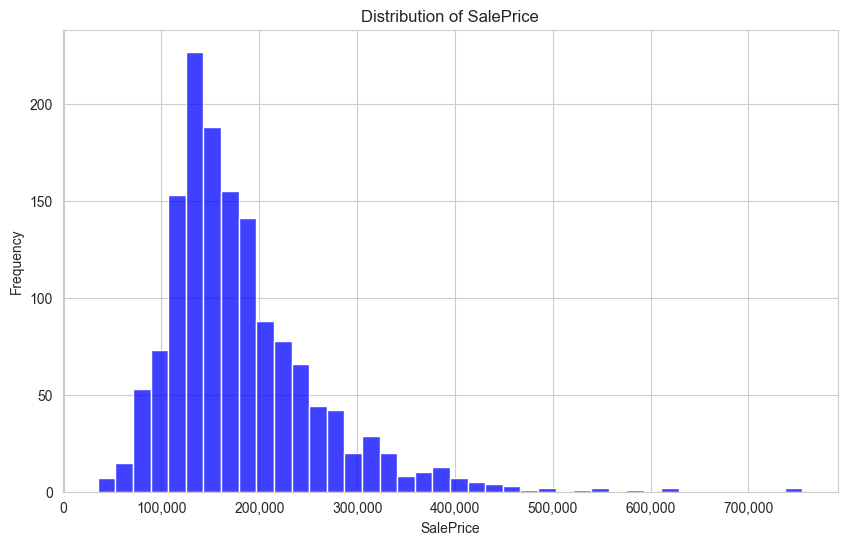

In [4]:
# 4. Exploring some of the most important variables

## 4.1 The response variable; SalePrice
print("\nSalePrice Summary:\n", all_data['SalePrice'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(all_data['SalePrice'].dropna(), bins=40, kde=False, color='blue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()


There are 37 numeric variables


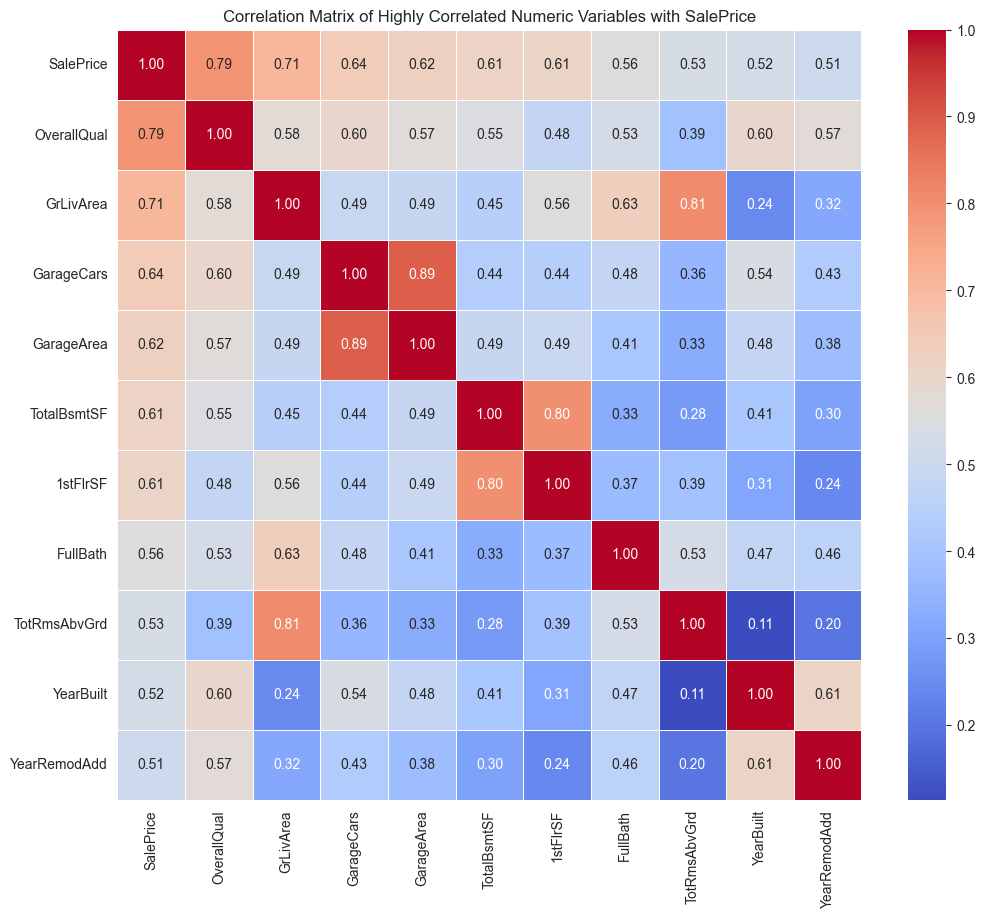

In [5]:
## 4.2 The most important numeric predictors

### 4.2.1 Correlations with SalePrice
numeric_cols = all_data.select_dtypes(include=np.number).columns.tolist()
print(f'There are {len(numeric_cols)} numeric variables')

all_num_var = all_data[numeric_cols]
cor_num_var = all_num_var.corr(numeric_only=True)

# Sort on decreasing correlations with SalePrice
cor_sorted = cor_num_var['SalePrice'].sort_values(ascending=False).to_frame()

# Select only high correlations (absolute value > 0.5)
CorHigh = cor_sorted[abs(cor_sorted['SalePrice']) > 0.5].index.tolist()
cor_num_var_high = cor_num_var.loc[CorHigh, CorHigh]

plt.figure(figsize=(12, 10))
sns.heatmap(cor_num_var_high, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Highly Correlated Numeric Variables with SalePrice')
plt.show()


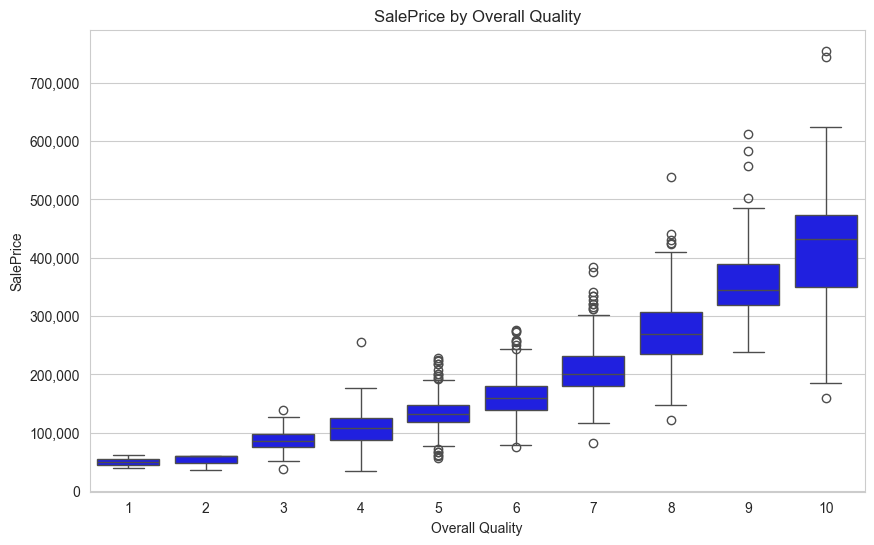

In [6]:
### 4.2.2 Overall Quality (OverallQual has the highest correlation with SalePrice)
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), color='blue')
plt.title('SalePrice by Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()


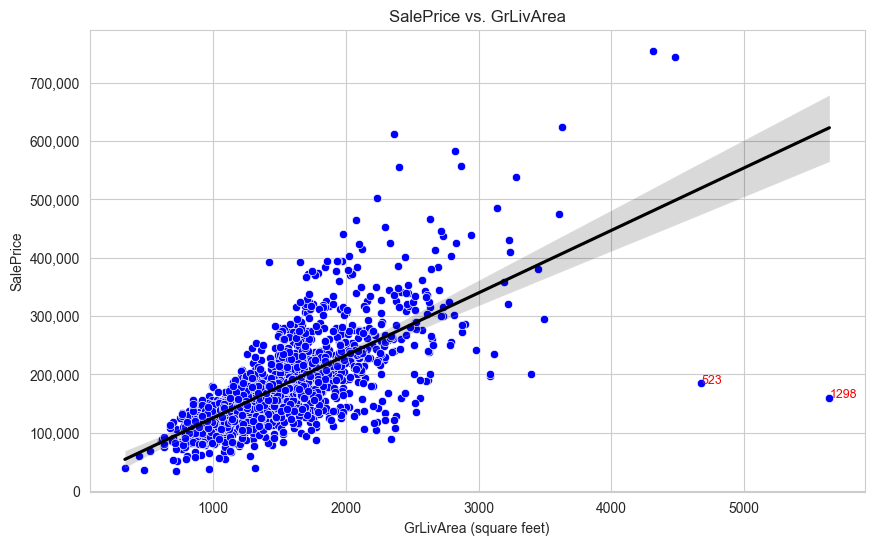


Checking the outliers: 524 & 1299 (Original R index +1 for Python)

      SalePrice  GrLivArea  OverallQual
523    184750.0       4676           10
1298   160000.0       5642           10


In [7]:
### 4.2.3 Above Grade (Ground) Living Area (square feet) (GrLivArea is the second one with the highest correlation with SalePrice)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), color='blue')
sns.regplot(x='GrLivArea', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), scatter=False, color='black')
plt.title('SalePrice vs. GrLivArea')
plt.xlabel('GrLivArea (square feet)')
plt.ylabel('SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Outlier annotation (simple text, not ggrepel equivalent)
outliers = all_data.loc[all_data['GrLivArea'] > 4500]
for i, row in outliers.dropna(subset=['SalePrice']).iterrows():
    plt.text(row['GrLivArea'], row['SalePrice'], str(i), fontsize=9, color='red')

plt.show()

print("\nChecking the outliers: 524 & 1299 (Original R index +1 for Python)\n")
print(all_data.loc[[523, 1298], ['SalePrice', 'GrLivArea', 'OverallQual']]) # R index 524 -> Python index 523, R index 1299 -> Python index 1298


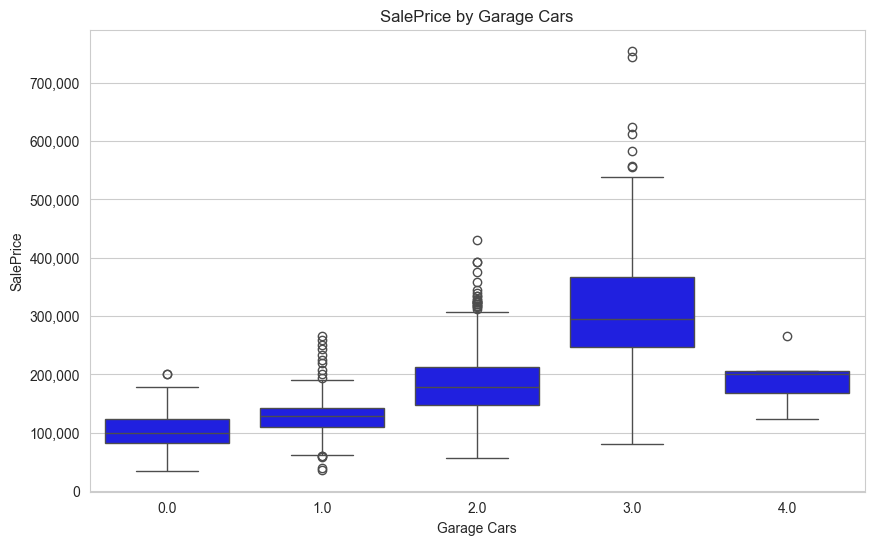

In [8]:
### 4.2.4 Garagecars (Garagecars is the third one with the highest correlation with SalePrice)
plt.figure(figsize=(10, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), color='blue')
plt.title('SalePrice by Garage Cars')
plt.xlabel('Garage Cars')
plt.ylabel('SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

# OverallQual과 Garagecar은 범주형이므로 boxplot 사용, GrLivArea는 연속형이므로 산점도 사용
## Boxplot은 범주형 x 축, 수치형 y 축일 때 자주 쓰이고, Scatter Plot은 둘 다 수치형일 때 주로 사용.


In [9]:
# 5 Missing data, label encoding, and factorizing variables
## 5.1 Completeness of the data(각 컬럼별 결측치 개수 확인 후 내림차순 정리)
missing_data = all_data.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print("\nMissing data by column:\n", missing_data)
print(f"총 {len(missing_data)}개의 컬럼에 걸쳐 결측치가 존재함을 확인할 수 있다.")



Missing data by column:
 PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
GarageCars         1
KitchenQual        1
GarageArea         1
SaleType           1
dtype: int64
총 35개의 컬럼에 걸쳐 결측치가 존재함을 확인할 수 있다.


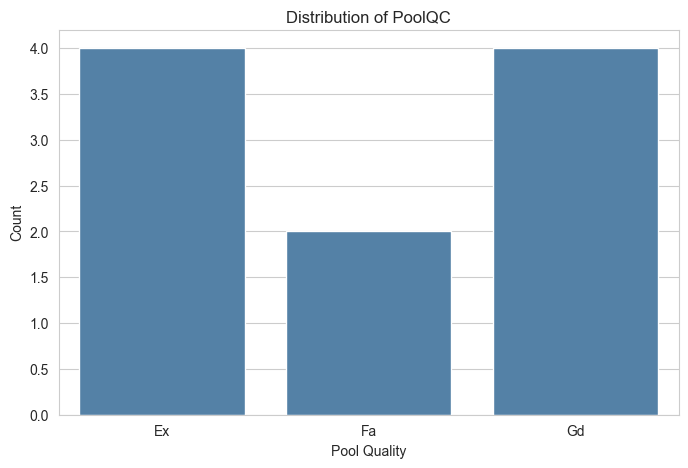

C:\Users\luke\AppData\Local\Temp\ipykernel_39512\2834550567.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='PoolQC', data=all_data, palette='Blues')



PoolQC value counts after imputation and encoding:
 PoolQC
0    2909
5       4
4       4
2       2
Name: count, dtype: int64

Problematic Pool entries (PoolArea > 0 but PoolQC is None):
       PoolArea  PoolQC  OverallQual
2420       368       0            4
2503       444       0            6
2599       561       0            3

PoolQC values after correction for problematic entries:
       PoolArea  PoolQC  OverallQual
2420       368       2            4
2503       444       3            6
2599       561       2            3


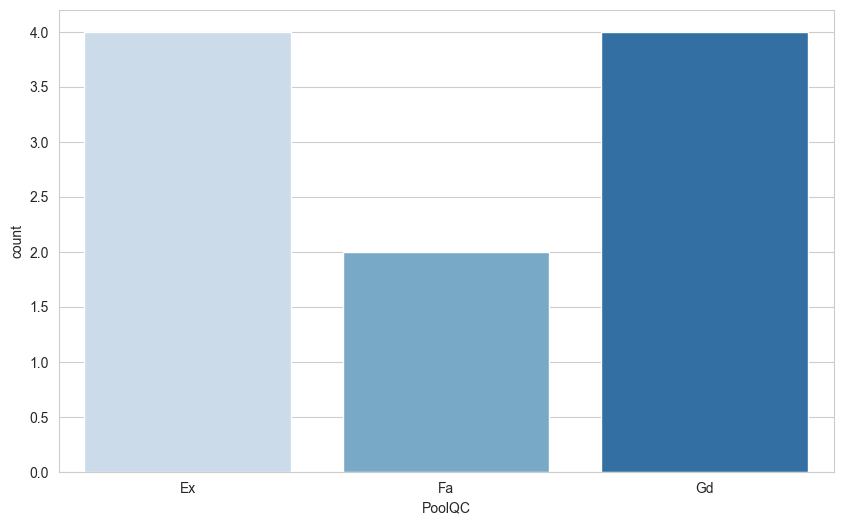

In [11]:
## 5.2 Imputing missing data(결측치 처리)
### 5.2.1 PoolQC(2909개)
plt.figure(figsize=(8, 5))
sns.countplot(x='PoolQC', data=all_data, color='steelblue')
plt.title('Distribution of PoolQC')
plt.xlabel('Pool Quality')
plt.ylabel('Count')
plt.show()
# Change the color palette from 'steelblue' to 'Blues'
sns.countplot(x='PoolQC', data=all_data, palette='Blues')
# NA는 수영장이 없는 경우로 간주하고, 'No Pool'로 대체
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')
# 라벨 인코딩
qualities_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
all_data['PoolQC'] = all_data['PoolQC'].map(qualities_map).astype(int)
print("\nPoolQC value counts after imputation and encoding:\n", all_data['PoolQC'].value_counts())

# 그러나 PoolArea는 0초과인데, PoolQC가 NA(None)인 경우가 존재.
problematic_pools = all_data[(all_data['PoolArea'] > 0) & (all_data['PoolQC'] == 0)]
print("\nProblematic Pool entries (PoolArea > 0 but PoolQC is None):\n", problematic_pools[['PoolArea', 'PoolQC', 'OverallQual']])

# no.2421, no. 2504, no.2600의 Pool의 QC를 각각의 OverallQual에 기초하여 결측치 채우기(순서대로 2,3,2) - Python Index는 2420, 2503, 2599
all_data.loc[2420, 'PoolQC'] = 2
all_data.loc[2503, 'PoolQC'] = 3
all_data.loc[2599, 'PoolQC'] = 2
print("\nPoolQC values after correction for problematic entries:\n", all_data.loc[[2420, 2503, 2599], ['PoolArea', 'PoolQC', 'OverallQual']])


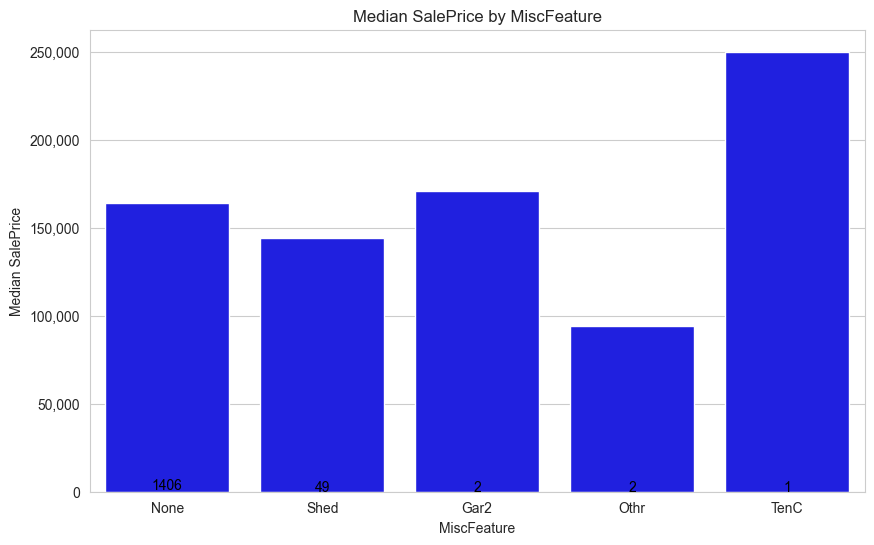


MiscFeature value counts:
 MiscFeature
None    2814
Shed      95
Gar2       5
Othr       4
TenC       1
Name: count, dtype: int64


In [12]:
### 5.2.2 Miscellaneous Feature(2814개)
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

# train만 사용한 데이터, 라벨은 각 범주에 속한 집의 개수
misc_df = all_data.dropna(subset=['SalePrice'])
misc_counts = misc_df['MiscFeature'].value_counts().reset_index()
misc_counts.columns = ['MiscFeature', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(x='MiscFeature', y='SalePrice', data=misc_df, estimator=np.median, color='blue', errorbar=None)
plt.title('Median SalePrice by MiscFeature')
plt.xlabel('MiscFeature')
plt.ylabel('Median SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

for index, row in misc_counts.iterrows():
    plt.text(index, row['count'], str(row['count']), color='black', ha="center")

plt.show()
print("\nMiscFeature value counts:\n", all_data['MiscFeature'].value_counts())
# Saleprice와 Misc는 서로 큰 관계가 없는 듯함(None의 비율이 너무 높기 때문)


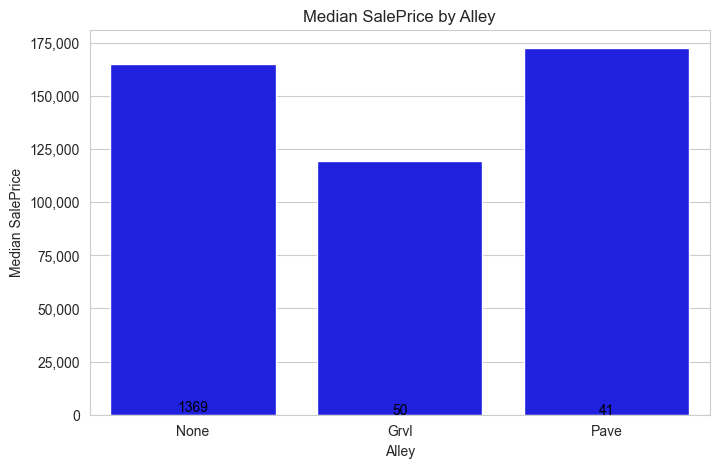


Alley value counts:
 Alley
None    2721
Grvl     120
Pave      78
Name: count, dtype: int64


In [13]:
### 5.2.3 Alley(2721개)
all_data['Alley'] = all_data['Alley'].fillna('None')

alley_df = all_data.dropna(subset=['SalePrice'])
alley_counts = alley_df['Alley'].value_counts().reset_index()
alley_counts.columns = ['Alley', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(x='Alley', y='SalePrice', data=alley_df, estimator=np.median, color='blue', errorbar=None)
plt.title('Median SalePrice by Alley')
plt.xlabel('Alley')
plt.ylabel('Median SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

for index, row in alley_counts.iterrows():
    plt.text(index, row['count'], str(row['count']), color='black', ha="center")

plt.show()
print("\nAlley value counts:\n", all_data['Alley'].value_counts())


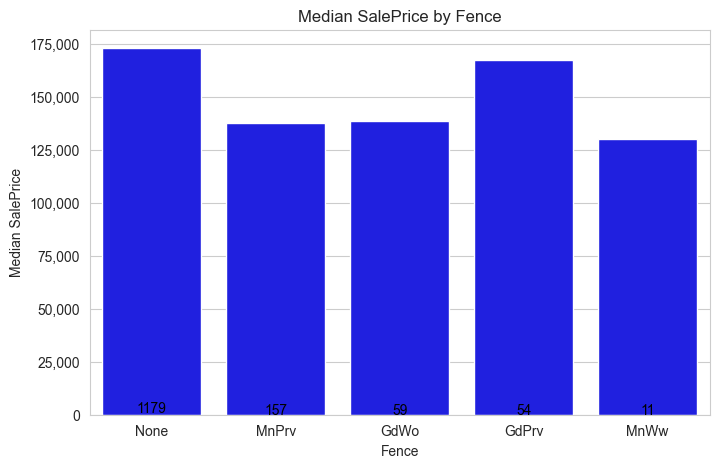


Fence value counts:
 Fence
None     2348
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: count, dtype: int64
         median  count
Fence                 
GdPrv  167500.0     59
GdWo   138750.0     54
MnPrv  137450.0    157
MnWw   130000.0     11
None   173000.0   1179


In [14]:
### 5.2.4 Fence(2340개)
all_data['Fence'] = all_data['Fence'].fillna('None')

fence_df = all_data.dropna(subset=['SalePrice'])
fence_counts = fence_df['Fence'].value_counts().reset_index()
fence_counts.columns = ['Fence', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(x='Fence', y='SalePrice', data=fence_df, estimator=np.median, color='blue', errorbar=None)
plt.title('Median SalePrice by Fence')
plt.xlabel('Fence')
plt.ylabel('Median SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

for index, row in fence_counts.iterrows():
    plt.text(index, row['count'], str(row['count']), color='black', ha="center")

plt.show()
print("\nFence value counts:\n", all_data['Fence'].value_counts())
# 신기하게도 Fence가 있는 집의 SalePrice가 더 낮다.
print(all_data.dropna(subset=['SalePrice']).groupby('Fence')['SalePrice'].agg(['median', 'count']))


In [15]:
### 5.2.5 Fireplace variables(1420개)
# 등급을 나타내므로 integer로 변환
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')
all_data['FireplaceQu'] = all_data['FireplaceQu'].map(qualities_map).astype(int)
print("\nFireplaceQu value counts:\n", all_data['FireplaceQu'].value_counts())
# 확인 결과 FireplaceQu에는 결측치 없음(None의 개수 = 1420 = 결측치 개수)



FireplaceQu value counts:
 FireplaceQu
0    1420
4     744
3     592
2      74
1      46
5      43
Name: count, dtype: int64


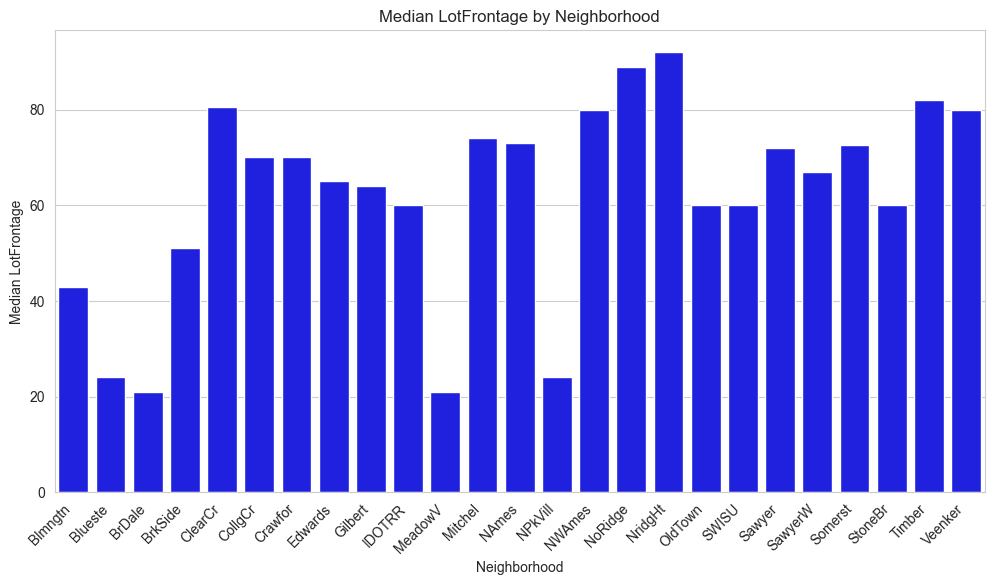


LotFrontage missing values after imputation: 0

LotShape value counts:
 LotShape
3    1859
2     968
1      76
0      16
Name: count, dtype: int64


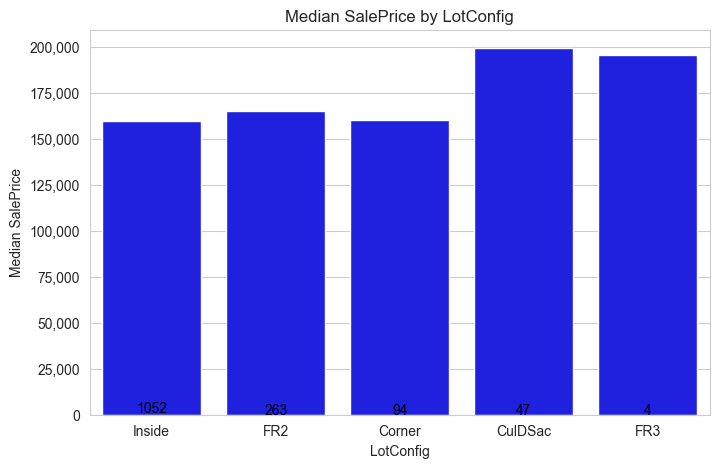


LotConfig value counts:
 LotConfig
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: count, dtype: int64


In [16]:
### 5.2.6 Lot variables(LotFront, LotShape, LotConfig)
# LotFront
lot_frontage_df = all_data.dropna(subset=['LotFrontage'])
lot_frontage_median = lot_frontage_df.groupby('Neighborhood')['LotFrontage'].median().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Neighborhood', y='LotFrontage', data=lot_frontage_median, color='blue')
plt.title('Median LotFrontage by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Median LotFrontage')
plt.xticks(rotation=45, ha='right')
plt.show()

## 동네에 따라 LotFrontage의 중앙값이 다름을 확인할 수 있다.
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print("\nLotFrontage missing values after imputation:", all_data['LotFrontage'].isnull().sum())

# LotShape: 여기는 결측치 X
lot_shape_map = {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
all_data['LotShape'] = all_data['LotShape'].map(lot_shape_map).astype(int)
print("\nLotShape value counts:\n", all_data['LotShape'].value_counts())

# LotConfig: 여기도 결측치는 X
lot_config_df = all_data.dropna(subset=['SalePrice'])
lot_config_counts = lot_config_df['LotConfig'].value_counts().reset_index()
lot_config_counts.columns = ['LotConfig', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(x='LotConfig', y='SalePrice', data=lot_config_df, estimator=np.median, color='blue', errorbar=None)
plt.title('Median SalePrice by LotConfig')
plt.xlabel('LotConfig')
plt.ylabel('Median SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

for index, row in lot_config_counts.iterrows():
    plt.text(index, row['count'], str(row['count']), color='black', ha="center")

plt.show()
print("\nLotConfig value counts:\n", all_data['LotConfig'].value_counts())


In [17]:
### 5.2.7 Garage variables (GarageType, GarageFinish, GarageQual, GarageCond...)
# GarageYrBlt
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(all_data['YearBuilt'])

# NA는 차고가 없다는 뜻일 수도 있으니, 157개의 결측치가 존재하는 GarageType 변수와 159개의 결측치가 존재하는 GarageFinish, GarageQual, GarageCond, GarageQual 변수를 비교한다.
# check if all 157 NAs are the same observations among the variables with 157/159 NAs
garage_na_check = all_data[['GarageType', 'GarageFinish', 'GarageCond', 'GarageQual']].isnull().all(axis=1)
print(f"All four garage quality/type columns are NA for {garage_na_check.sum()} rows.")

# Find the 2 additional NAs
problematic_garage = all_data[~all_data['GarageType'].isnull() & all_data['GarageFinish'].isnull()]
print("\nProblematic garage entries (GarageType not NA but GarageFinish is NA):\n")
print(problematic_garage[['GarageCars', 'GarageArea', 'GarageType', 'GarageCond', 'GarageQual', 'GarageFinish']])

# 2127과 2577이 문제, 2127은 차고가 존재하나 2577은 차고가 존재하지 않는 것으로 보이기에, 수정하기
# Python index: 2126, 2576

# 2126을 최빈값으로 수정
for col in ['GarageCond', 'GarageQual', 'GarageFinish']:
    mode_val = all_data[col].mode()[0]
    all_data.loc[2126, col] = mode_val

# 2576을 차고 없음으로 수정
all_data.loc[2576, 'GarageCars'] = 0
all_data.loc[2576, 'GarageArea'] = 0
all_data.loc[2576, 'GarageType'] = np.nan # This will be filled as 'No Garage' below

# check if NAs of the character variables are now all 158
garage_na_check_after_fix = all_data[['GarageType', 'GarageFinish', 'GarageCond', 'GarageQual']].isnull().all(axis=1)
print(f"\nAll four garage quality/type columns are NA after fix for {garage_na_check_after_fix.sum()} rows.")

# GarageType
all_data['GarageType'] = all_data['GarageType'].fillna('No Garage')
print("\nGarageType value counts:\n", all_data['GarageType'].value_counts())

# GarageFinish
all_data['GarageFinish'] = all_data['GarageFinish'].fillna('None')
finish_map = {'None':0, 'Unf':1, 'RFn':2, 'Fin':3}
all_data['GarageFinish'] = all_data['GarageFinish'].map(finish_map).astype(int)
print("\nGarageFinish value counts:\n", all_data['GarageFinish'].value_counts())

# GarageQual
all_data['GarageQual'] = all_data['GarageQual'].fillna('None')
all_data['GarageQual'] = all_data['GarageQual'].map(qualities_map).astype(int)
print("\nGarageQual value counts:\n", all_data['GarageQual'].value_counts())

# GarageCond
all_data['GarageCond'] = all_data['GarageCond'].fillna('None')
all_data['GarageCond'] = all_data['GarageCond'].map(qualities_map).astype(int)
print("\nGarageCond value counts:\n", all_data['GarageCond'].value_counts())

# 모두 결측치 개수와 None 개수가 같으므로 문제 X


All four garage quality/type columns are NA for 157 rows.

Problematic garage entries (GarageType not NA but GarageFinish is NA):

      GarageCars  GarageArea GarageType GarageCond GarageQual GarageFinish
2126         1.0       360.0     Detchd        NaN        NaN          NaN
2576         NaN         NaN     Detchd        NaN        NaN          NaN

All four garage quality/type columns are NA after fix for 158 rows.

GarageType value counts:
 GarageType
Attchd       1723
Detchd        778
BuiltIn       186
No Garage     158
Basment        36
2Types         23
CarPort        15
Name: count, dtype: int64

GarageFinish value counts:
 GarageFinish
1    1231
2     811
3     719
0     158
Name: count, dtype: int64

GarageQual value counts:
 GarageQual
3    2605
0     158
2     124
4      24
1       5
5       3
Name: count, dtype: int64

GarageCond value counts:
 GarageCond
3    2655
0     158
2      74
4      15
1      14
5       3
Name: count, dtype: int64


In [18]:
### 5.2.8 Basement Variables: There are 11 variables related to the basement and Five of those have 79-82 NAs, six have one or two NAs
#**여러 변수(Bsmt 관련 변수)**의 결측치(NA)가 같은 행에서 동시에 발생하는지 확인하는 것, 같은 행에서만 NA가 발생하면 → 해당 집은 지하실이 없어서 모두 NA인 것일 수 있음
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
bsmt_na_all = all_data[bsmt_cols].isnull().all(axis=1)
print(f"All five Bsmt quality/finish columns are NA for {bsmt_na_all.sum()} rows.")

# 지하실 정보가 일부만 비어있는 행 확인: 지하실이 없으면 지하실 관련 모든 항목이 NA여야 하는데, 그렇지 않은 집들을 확인 → 수작업/논리 기반으로 결측치 처리
problematic_bsmt = all_data[~all_data['BsmtFinType1'].isnull() & 
                            (all_data['BsmtCond'].isnull() | all_data['BsmtQual'].isnull() | 
                             all_data['BsmtExposure'].isnull() | all_data['BsmtFinType2'].isnull())]
print("\nProblematic basement entries (some Bsmt cols NA, but not all):\n")
print(problematic_bsmt[bsmt_cols])

# 위 작업에서 거른 9개의 집(333, 949, 1488, 2041, 2186, 2218, 2219, 2349, 2525)의 결측치 처리: 최반값 (Python index: -1)
all_data.loc[332, 'BsmtFinType2'] = all_data['BsmtFinType2'].mode()[0]
all_data.loc[[948, 1487, 2348], 'BsmtExposure'] = all_data['BsmtExposure'].mode()[0]
all_data.loc[[2040, 2185, 2524], 'BsmtCond'] = all_data['BsmtCond'].mode()[0]
all_data.loc[[2217, 2218], 'BsmtQual'] = all_data['BsmtQual'].mode()[0]

# BsmtQual
all_data['BsmtQual'] = all_data['BsmtQual'].fillna('None')
all_data['BsmtQual'] = all_data['BsmtQual'].map(qualities_map).astype(int)
print("\nBsmtQual value counts:\n", all_data['BsmtQual'].value_counts())

# BsmtCond
all_data['BsmtCond'] = all_data['BsmtCond'].fillna('None')
all_data['BsmtCond'] = all_data['BsmtCond'].map(qualities_map).astype(int)
print("\nBsmtCond value counts:\n", all_data['BsmtCond'].value_counts())

# BsmtExposure
all_data['BsmtExposure'] = all_data['BsmtExposure'].fillna('None')
exposure_map = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
all_data['BsmtExposure'] = all_data['BsmtExposure'].map(exposure_map).astype(int)
print("\nBsmtExposure value counts:\n", all_data['BsmtExposure'].value_counts())

# BsmtFinType1
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].fillna('None')
fintype_map = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map(fintype_map).astype(int)
print("\nBsmtFinType1 value counts:\n", all_data['BsmtFinType1'].value_counts())

# BsmtFinType2
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].fillna('None')
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].map(fintype_map).astype(int)
print("\nBsmtFinType2 value counts:\n", all_data['BsmtFinType2'].value_counts())

# 1~2개의 결측치가 있는 6개의 변수(컬럼) 다루기
bsmt_num_cols = ['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
problematic_bsmt_num = all_data[all_data[bsmt_num_cols].isnull().any(axis=1)]
print("\nProblematic numeric basement entries:\n")
print(problematic_bsmt_num[['BsmtQual'] + bsmt_num_cols])

# NA 값은 존재하지 않음으로 모두 처리 (0으로 대체)
for col in bsmt_num_cols:
    all_data[col] = all_data[col].fillna(0)
print("\nMissing values in numeric basement columns after imputation:\n", all_data[bsmt_num_cols].isnull().sum())


All five Bsmt quality/finish columns are NA for 79 rows.

Problematic basement entries (some Bsmt cols NA, but not all):

     BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
332        Gd       TA           No          GLQ          NaN
948        Gd       TA          NaN          Unf          Unf
1487       Gd       TA          NaN          Unf          Unf
2040       Gd      NaN           Mn          GLQ          Rec
2185       TA      NaN           No          BLQ          Unf
2217      NaN       Fa           No          Unf          Unf
2218      NaN       TA           No          Unf          Unf
2348       Gd       TA          NaN          Unf          Unf
2524       TA      NaN           Av          ALQ          Unf

BsmtQual value counts:
 BsmtQual
3    1285
4    1209
5     258
2      88
0      79
Name: count, dtype: int64

BsmtCond value counts:
 BsmtCond
3    2609
4     122
2     104
0      79
1       5
Name: count, dtype: int64

BsmtExposure value counts:
 BsmtExpos

In [20]:
### 5.2.9 Masonry variables : Masonry veneer type(24 NAs), and masonry veneer area(23 NAs)
# 겹치는지 확인
mas_na_check = all_data[['MasVnrType', 'MasVnrArea']].isnull().all(axis=1)
print(f"MasVnrType and MasVnrArea are both NA for {mas_na_check.sum()} rows.")

# 안겹치는 하나 찾기: 2611번 (Python index: 2610)
problematic_mas = all_data[all_data['MasVnrType'].isnull() & ~all_data['MasVnrArea'].isnull()]
print("\nProblematic MasVnr entry:\n")
print(problematic_mas[['MasVnrType', 'MasVnrArea']])

# 2610번 수정
masvnr_mode = all_data['MasVnrType'].mode()
# Use the 2nd mode if it exists, otherwise use the 1st
all_data.loc[2610, 'MasVnrType'] = masvnr_mode[1] if len(masvnr_mode) > 1 else masvnr_mode[0]
print("\nMasVnr entry 2610 after fix:\n", all_data.loc[2610, ['MasVnrType', 'MasVnrArea']])

# Masonry Veneer이 진짜 없는 집들을 None으로 처리
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

print(all_data.dropna(subset=['SalePrice']).groupby('MasVnrType')['SalePrice'].agg(['median', 'count']).sort_values(by='median'))

# 라벨링 해주기
masonry_map = {'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2}
all_data['MasVnrType'] = all_data['MasVnrType'].map(masonry_map).astype(int)
print("\nMasVnrType value counts:\n", all_data['MasVnrType'].value_counts())

# MasVnrArea은 수치형이므로 결측치는 모두 0으로 처리
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
print("\nMasVnrArea missing values after imputation:", all_data['MasVnrArea'].isnull().sum())


MasVnrType and MasVnrArea are both NA for 23 rows.

Problematic MasVnr entry:

     MasVnrType  MasVnrArea
1           NaN         0.0
3           NaN         0.0
5           NaN         0.0
8           NaN         0.0
9           NaN         0.0
...         ...         ...
2913        NaN         0.0
2914        NaN         0.0
2915        NaN         0.0
2916        NaN         0.0
2917        NaN         0.0

[1743 rows x 2 columns]

MasVnr entry 2610 after fix:
 MasVnrType    BrkFace
MasVnrArea      198.0
Name: 2610, dtype: object
              median  count
MasVnrType                 
BrkCmn      139000.0     15
None        143125.0    872
BrkFace     181000.0    445
Stone       246839.0    128

MasVnrType value counts:
 MasVnrType
0    1790
1     880
2     249
Name: count, dtype: int64

MasVnrArea missing values after imputation: 0


In [21]:
### 5.2.10 MS Zoning: Identifies the general zoning classification of the sale
# 결측치가 4개이므로 최빈값으로 결측치 처리
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
print("\nMSZoning value counts:\n", all_data['MSZoning'].value_counts())



MSZoning value counts:
 MSZoning
RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: count, dtype: int64


In [22]:
### 5.2.11 Kitchen variables
# 결측치가 1개이므로 최빈값으로 결측치 처리
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA') #replace with most common value
all_data['KitchenQual'] = all_data['KitchenQual'].map(qualities_map).astype(int)
print("\nKitchenQual value counts:\n", all_data['KitchenQual'].value_counts())
print("\nKitchenAbvGr value counts:\n", all_data['KitchenAbvGr'].value_counts())



KitchenQual value counts:
 KitchenQual
3    1493
4    1151
5     205
2      70
Name: count, dtype: int64

KitchenAbvGr value counts:
 KitchenAbvGr
1    2785
2     129
0       3
3       2
Name: count, dtype: int64


In [23]:
### 5.2.12 Utilities : Type of utilities available
# 결측치가 2개 그러나
print("\nUtilities value counts:\n", all_data['Utilities'].value_counts())
# NoSeWa는 단 한 집.
print("\nUtilities 'NoSeWa' or NA entries:\n", all_data[all_data['Utilities'].isnull() | (all_data['Utilities'] == 'NoSeWa')].iloc[:, :9])
# 너무 AllPub으로 몰려있으므로, 학습의 의미가 없음 → 행 제거가 아닌 컬럼 제거
all_data = all_data.drop('Utilities', axis=1)
print("\n'Utilities' column removed. Current shape:", all_data.shape)



Utilities value counts:
 Utilities
AllPub    2916
NoSeWa       1
Name: count, dtype: int64

Utilities 'NoSeWa' or NA entries:
       MSSubClass MSZoning  LotFrontage  LotArea Street Alley  LotShape  \
944           20       RL         82.0    14375   Pave  None         2   
1915          30       RL        109.0    21780   Grvl  None         3   
1945          20       RL         64.0    31220   Pave  None         2   

     LandContour Utilities  
944          Lvl    NoSeWa  
1915         Lvl       NaN  
1945         Bnk       NaN  

'Utilities' column removed. Current shape: (2919, 79)


In [24]:
### 5.2.13 Home functionality
# 결측치 1개: 최빈값 처리
all_data['Functional'] = all_data['Functional'].fillna(all_data['Functional'].mode()[0])
functional_map = {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}
all_data['Functional'] = all_data['Functional'].map(functional_map).astype(int)
print("\nFunctional value counts:\n", all_data['Functional'].value_counts())



Functional value counts:
 Functional
7    2719
5      70
6      65
4      35
3      19
2       9
1       2
Name: count, dtype: int64


In [25]:
### 5.2.14 Exterior variables: 2 variables have 1 NA, 2 variables have no NAs.
# Exterior1st: Exterior covering on house: 1 NA. Values are categorical.: 최빈값 처리
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
print("\nExterior1st value counts:\n", all_data['Exterior1st'].value_counts())

# Exterior2nd: Exterior covering on house(if more than one material): 1 NA. Values are categorical.: 최빈값 처리
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
print("\nExterior2nd value counts:\n", all_data['Exterior2nd'].value_counts())

# ExterQual: Evaluates the quality of the material on the exterior: 결측치 없음
# 순서형으로 변환
all_data['ExterQual'] = all_data['ExterQual'].map(qualities_map).astype(int)
print("\nExterQual value counts:\n", all_data['ExterQual'].value_counts())

# ExterCond: Evaluates the present condition of the material on the exterior: 결측치 없음
# 순서형으로 변환
all_data['ExterCond'] = all_data['ExterCond'].map(qualities_map).astype(int)
print("\nExterCond value counts:\n", all_data['ExterCond'].value_counts())



Exterior1st value counts:
 Exterior1st
VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
Name: count, dtype: int64

Exterior2nd value counts:
 Exterior2nd
VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
BrkFace      47
Stucco       47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: count, dtype: int64

ExterQual value counts:
 ExterQual
3    1798
4     979
5     107
2      35
Name: count, dtype: int64

ExterCond value counts:
 ExterCond
3    2538
4     299
2      67
5      12
1       3
Name: count, dtype: int64


In [26]:
### 5.2.15 Electrical system
# Electrical: Electrical system: 결측치 1개: 최빈값 처리
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
print("\nElectrical value counts:\n", all_data['Electrical'].value_counts())



Electrical value counts:
 Electrical
SBrkr    2672
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: count, dtype: int64


In [27]:
### 5.2.16 Sale Type and Condition
# SaleType: Type of sale: 결측치 1개: 최빈값 처리
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
print("\nSaleType value counts:\n", all_data['SaleType'].value_counts())
# SaleCondition: Condition of sale: 결측치 없음
print("\nSaleCondition value counts:\n", all_data['SaleCondition'].value_counts())



SaleType value counts:
 SaleType
WD       2526
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: count, dtype: int64

SaleCondition value counts:
 SaleCondition
Normal     2402
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: count, dtype: int64



Foundation value counts:
 Foundation
PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: count, dtype: int64

Heating value counts:
 Heating
GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: count, dtype: int64

RoofStyle value counts:
 RoofStyle
Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: count, dtype: int64

RoofMatl value counts:
 RoofMatl
CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: count, dtype: int64

LandContour value counts:
 LandContour
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: count, dtype: int64

LandSlope value counts:
 LandSlope
2    2778
1     125
0      16
Name: count, dtype: int64


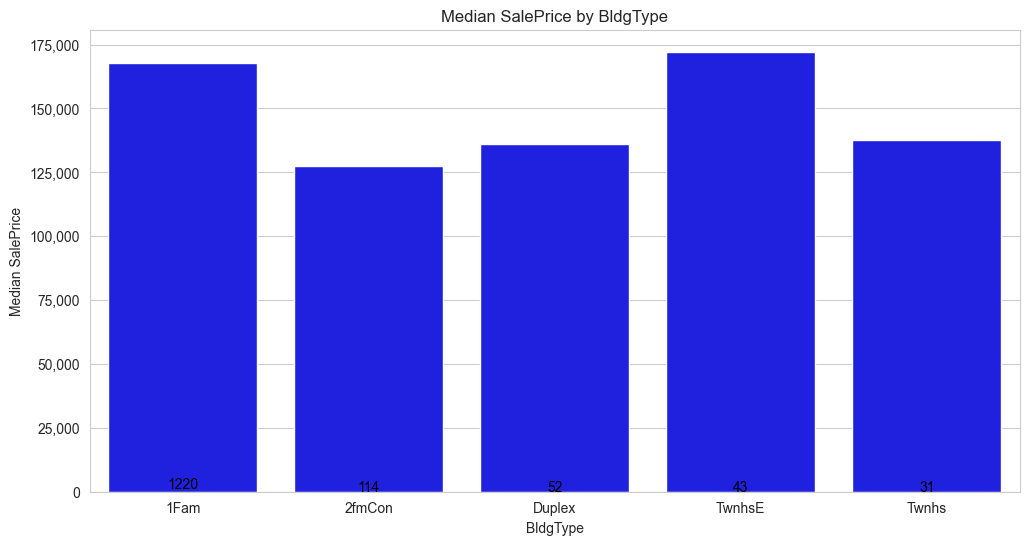


BldgType value counts:
 BldgType
1Fam      2425
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: count, dtype: int64

HouseStyle value counts:
 HouseStyle
1Story    1471
2Story     872
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: count, dtype: int64

Neighborhood value counts:
 Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: count, dtype: int64

Condition1 value counts:
 Condition1
Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: count, dtype: int64

Condition2 value counts:
 Condition2
N

In [28]:
### 5.3. 문자형 변수 처리하기: 순서형은 라벨인코딩, 그 외는 범주형으로 변환
### 5.3.1 Foundation
print("\nFoundation value counts:\n", all_data['Foundation'].value_counts())
### 5.3.2 Heating and airco
print("\nHeating value counts:\n", all_data['Heating'].value_counts())
### 5.3.3 Roof
print("\nRoofStyle value counts:\n", all_data['RoofStyle'].value_counts())
print("\nRoofMatl value counts:\n", all_data['RoofMatl'].value_counts())
### 5.3.4 Land
print("\nLandContour value counts:\n", all_data['LandContour'].value_counts())
land_slope_map = {'Sev':0, 'Mod':1, 'Gtl':2}
all_data['LandSlope'] = all_data['LandSlope'].map(land_slope_map).astype(int)
print("\nLandSlope value counts:\n", all_data['LandSlope'].value_counts())
### 5.3.5 Dwelling
# BldgType: Type of dwelling
bldg_type_df = all_data.dropna(subset=['SalePrice'])
bldg_type_counts = bldg_type_df['BldgType'].value_counts().reset_index()
bldg_type_counts.columns = ['BldgType', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(x='BldgType', y='SalePrice', data=bldg_type_df, estimator=np.median, color='blue', errorbar=None)
plt.title('Median SalePrice by BldgType')
plt.xlabel('BldgType')
plt.ylabel('Median SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

for index, row in bldg_type_counts.iterrows():
    plt.text(index, row['count'], str(row['count']), color='black', ha="center")
plt.show()
# 순서형 아님
print("\nBldgType value counts:\n", all_data['BldgType'].value_counts())
# HouseStyle: Style of dwelling
print("\nHouseStyle value counts:\n", all_data['HouseStyle'].value_counts())
### 5.3.6 Neighborhood and Conditions
print("\nNeighborhood value counts:\n", all_data['Neighborhood'].value_counts())
print("\nCondition1 value counts:\n", all_data['Condition1'].value_counts())
print("\nCondition2 value counts:\n", all_data['Condition2'].value_counts())

### 5.3.7 Pavement of Street & Driveway
street_map = {'Grvl':0, 'Pave':1}
all_data['Street'] = all_data['Street'].map(street_map).astype(int)
print("\nStreet value counts:\n", all_data['Street'].value_counts())

paved_drive_map = {'N':0, 'P':1, 'Y':2}
all_data['PavedDrive'] = all_data['PavedDrive'].map(paved_drive_map).astype(int)
print("\nPavedDrive value counts:\n", all_data['PavedDrive'].value_counts())


YrSold dtype: int64
MoSold dtype: int64


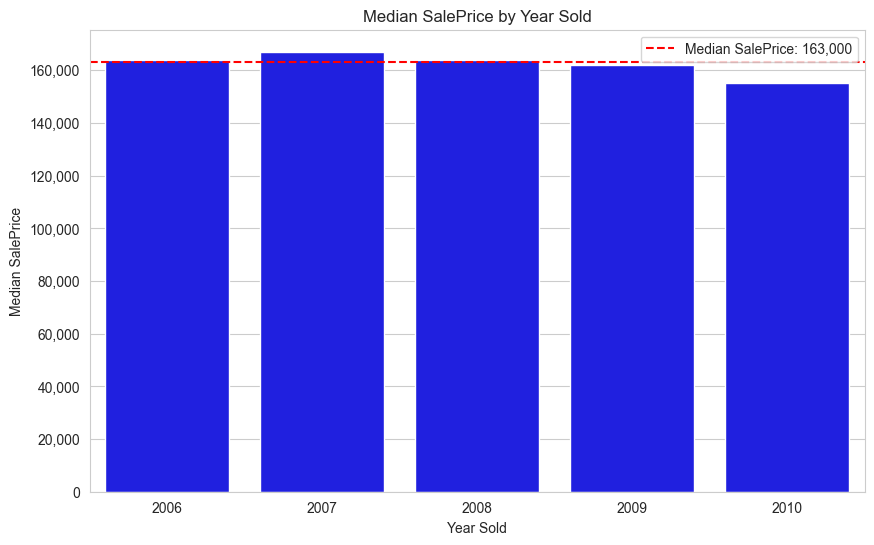

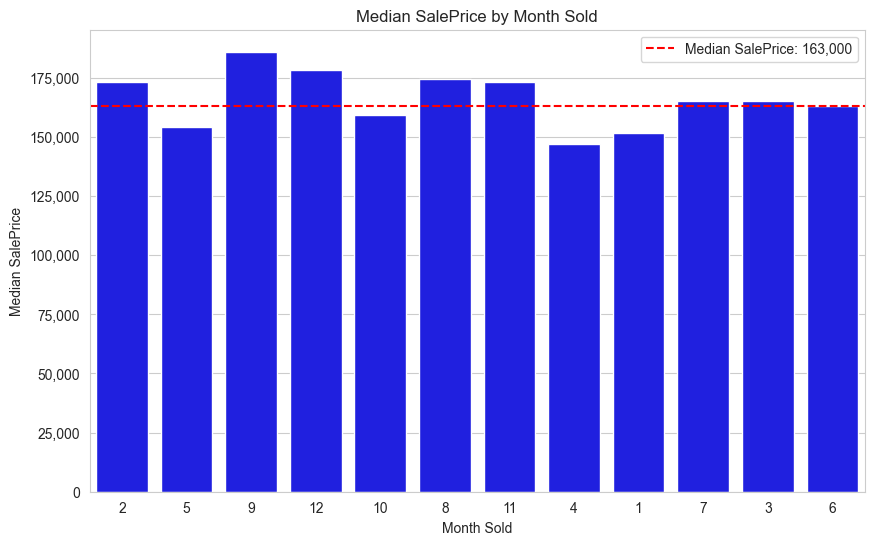

MSSubClass dtype: int64

MSSubClass dtype after revalue: object


In [29]:
## 5.4 수치형 변수 범주화
### 5.4.1 Year and Month Sold
print("YrSold dtype:", all_data['YrSold'].dtype)
print("MoSold dtype:", all_data['MoSold'].dtype)
all_data['MoSold'] = all_data['MoSold'].astype(str) # Convert to string for plotting as categorical

ys = plt.figure(figsize=(10, 6))
sns.barplot(x='YrSold', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), estimator=np.median, color='blue', errorbar=None)
plt.title('Median SalePrice by Year Sold')
plt.xlabel('Year Sold')
plt.ylabel('Median SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.axhline(y=all_data['SalePrice'].median(), color='red', linestyle='--', label=f'Median SalePrice: {all_data["SalePrice"].median():,.0f}')
plt.legend()
plt.show()

ms = plt.figure(figsize=(10, 6))
sns.barplot(x='MoSold', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), estimator=np.median, color='blue', errorbar=None)
plt.title('Median SalePrice by Month Sold')
plt.xlabel('Month Sold')
plt.ylabel('Median SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.axhline(y=all_data['SalePrice'].median(), color='red', linestyle='--', label=f'Median SalePrice: {all_data["SalePrice"].median():,.0f}')
plt.legend()
plt.show()
# 아마 년+월 합쳐서 변수 만들듯. (여기서는 만들지 않고 나중에 파생변수 추가 시 고려)

### 5.4.2 MSSubClass:  Identifies the type of dwelling involved in the sale.
print("MSSubClass dtype:", all_data['MSSubClass'].dtype)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

#revalue for better readability
mssubclass_map = {
    '20':'1 story 1946+', '30':'1 story 1945-', '40':'1 story unf attic', 
    '45':'1,5 story unf', '50':'1,5 story fin', '60':'2 story 1946+', 
    '70':'2 story 1945-', '75':'2,5 story all ages', '80':'split/multi level', 
    '85':'split foyer', '90':'duplex all style/age', '120':'1 story PUD 1946+', 
    '150':'1,5 story PUD all', '160':'2 story PUD 1946+', '180':'PUD multilevel', 
    '190':'2 family conversion'
}
all_data['MSSubClass'] = all_data['MSSubClass'].replace(mssubclass_map)
print("\nMSSubClass dtype after revalue:", all_data['MSSubClass'].dtype)


There are 54 numeric variables, and 25 categoric variables


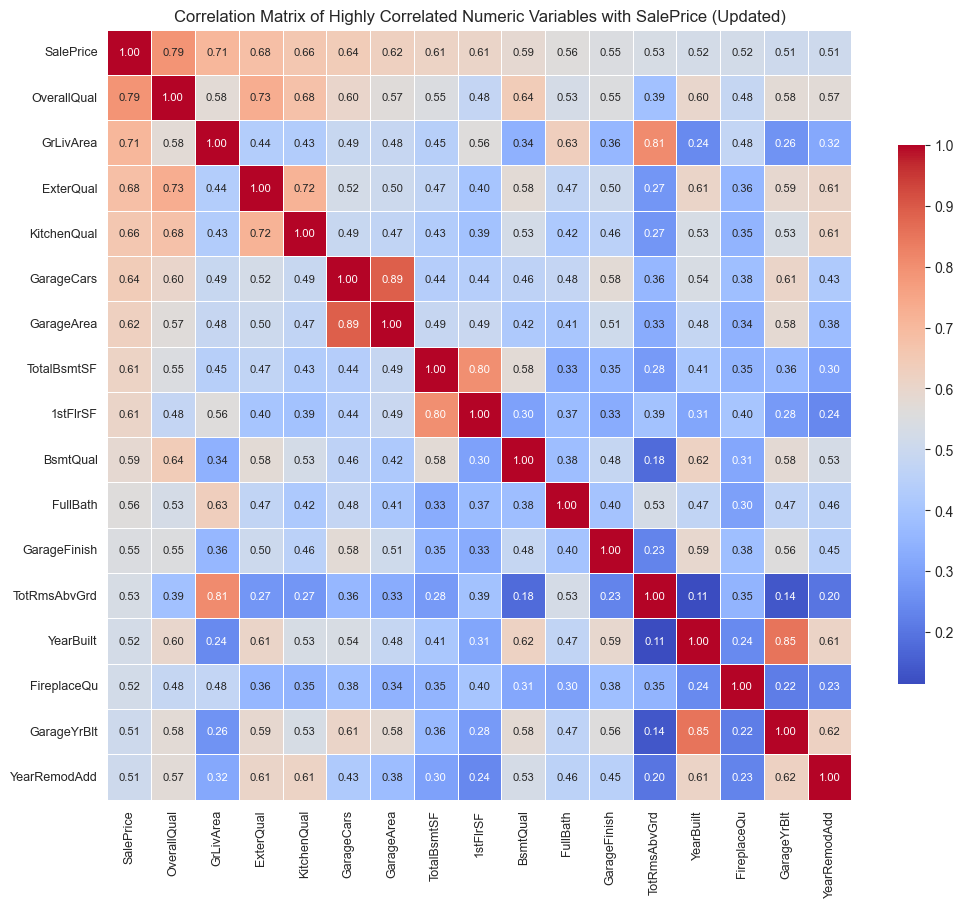

In [30]:
# 6. 시각화를 통해 변수들을 다시 살펴보기
numeric_vars = all_data.select_dtypes(include=np.number).columns.tolist()
factor_vars = all_data.select_dtypes(include='object').columns.tolist()
print(f'There are {len(numeric_vars)} numeric variables, and {len(factor_vars)} categoric variables')

## 6.1 Corr
all_num_var = all_data[numeric_vars]
cor_num_var = all_num_var.corr(numeric_only=True)

#sort on decreasing correlations with SalePrice
cor_sorted = cor_num_var['SalePrice'].sort_values(ascending=False).to_frame()
#select only high corelations
CorHigh = cor_sorted[abs(cor_sorted['SalePrice']) > 0.5].index.tolist()
cor_num_var = cor_num_var.loc[CorHigh, CorHigh]

plt.figure(figsize=(12, 10))
sns.heatmap(cor_num_var, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'shrink': 0.7}, annot_kws={'size': 8})
plt.title('Correlation Matrix of Highly Correlated Numeric Variables with SalePrice (Updated)')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()


C:\Users\luke\AppData\Local\Temp\ipykernel_39512\2506850203.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variables', data=imp_df.head(20), palette='viridis')


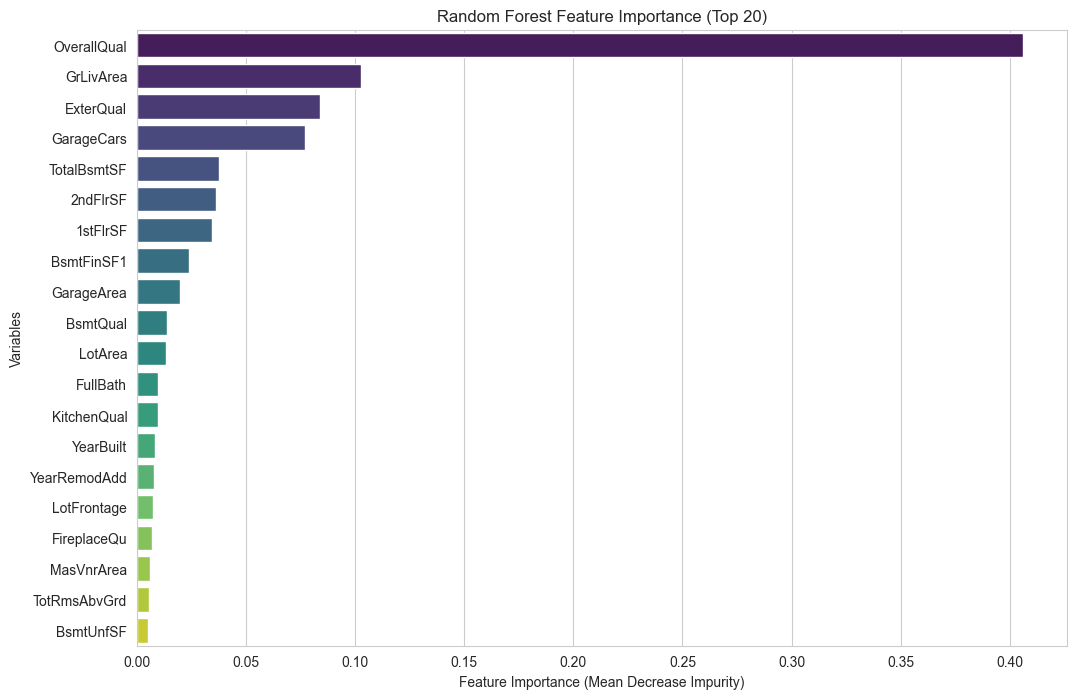

In [31]:
## 6.2 Random Forest를 통해 피처 중요도 파악하기
# SalePrice가 NaN이 아닌 행만 사용 (훈련 데이터)
train_rf = all_data[all_data['SalePrice'].notna()].copy()
X_rf = train_rf.drop('SalePrice', axis=1)
y_rf = train_rf['SalePrice']

# 범주형 변수를 원-핫 인코딩
X_rf = pd.get_dummies(X_rf, dummy_na=False)

# 결측치 처리 (RandomForest는 결측치를 허용하지 않으므로, 0으로 간단히 채웁니다)
# 이 단계에서는 모든 결측치가 처리되었을 것으로 예상되지만, 혹시 모를 경우를 대비합니다.
X_rf = X_rf.fillna(0)

set_seed = 2018
rf_model = RandomForestRegressor(n_estimators=100, random_state=set_seed, n_jobs=-1, max_features=0.7)
rf_model.fit(X_rf, y_rf)

imp_df = pd.DataFrame({
    'Variables': X_rf.columns,
    'Importance': rf_model.feature_importances_
})
imp_df = imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Variables', data=imp_df.head(20), palette='viridis')
plt.title('Random Forest Feature Importance (Top 20)')
plt.xlabel('Feature Importance (Mean Decrease Impurity)')
plt.ylabel('Variables')
plt.show()


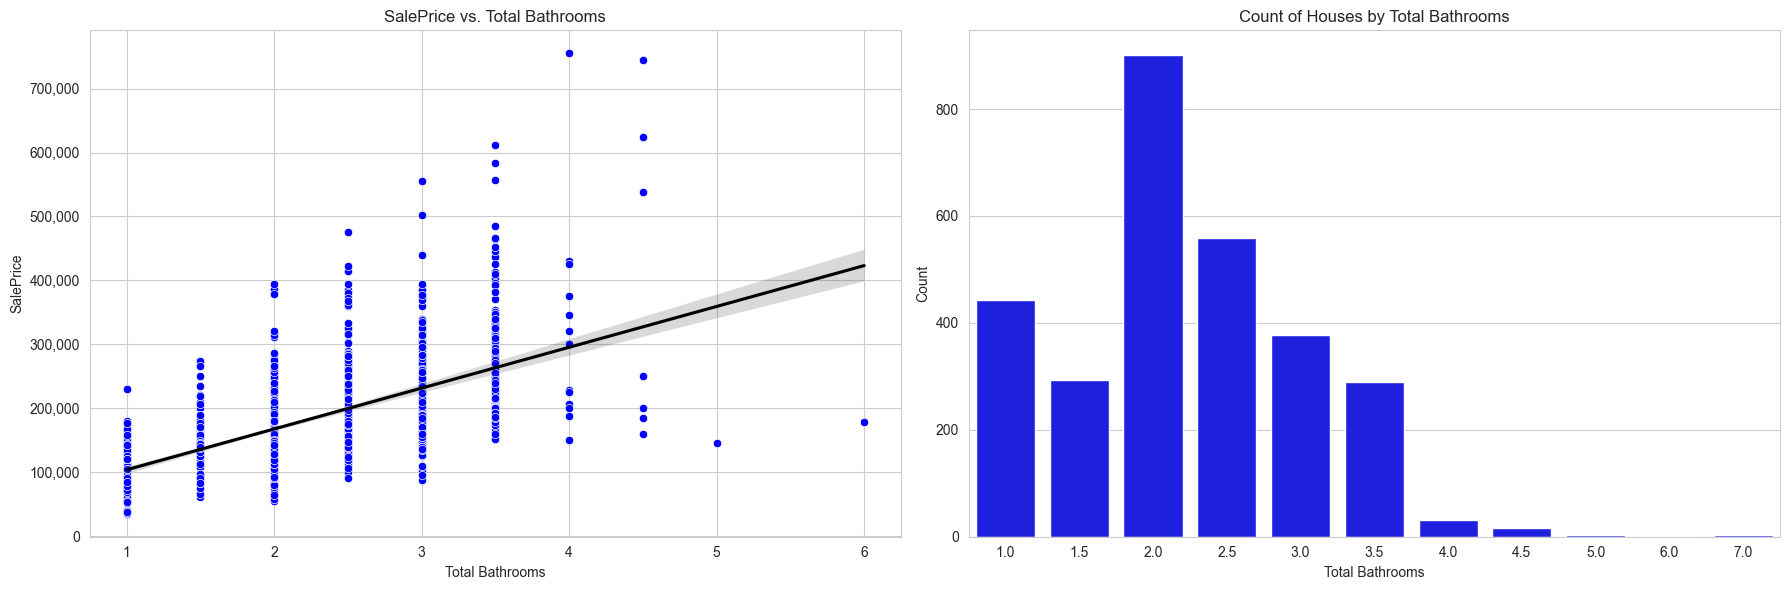

In [33]:
# 7 Feature engineering
## 7.1 Total number of Bathrooms
all_data['TotBathrooms'] = (
    all_data['FullBath'] + (all_data['HalfBath'] * 0.5) +
    all_data['BsmtFullBath'] + (all_data['BsmtHalfBath'] * 0.5)
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot(x='TotBathrooms', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), color='blue', ax=axes[0])
sns.regplot(x='TotBathrooms', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), scatter=False, color='black', ax=axes[0])
axes[0].set_title('SalePrice vs. Total Bathrooms')
axes[0].set_xlabel('Total Bathrooms')
axes[0].set_ylabel('SalePrice')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.countplot(x='TotBathrooms', data=all_data, ax=axes[1], color='blue')
axes[1].set_title('Count of Houses by Total Bathrooms')
axes[1].set_xlabel('Total Bathrooms')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


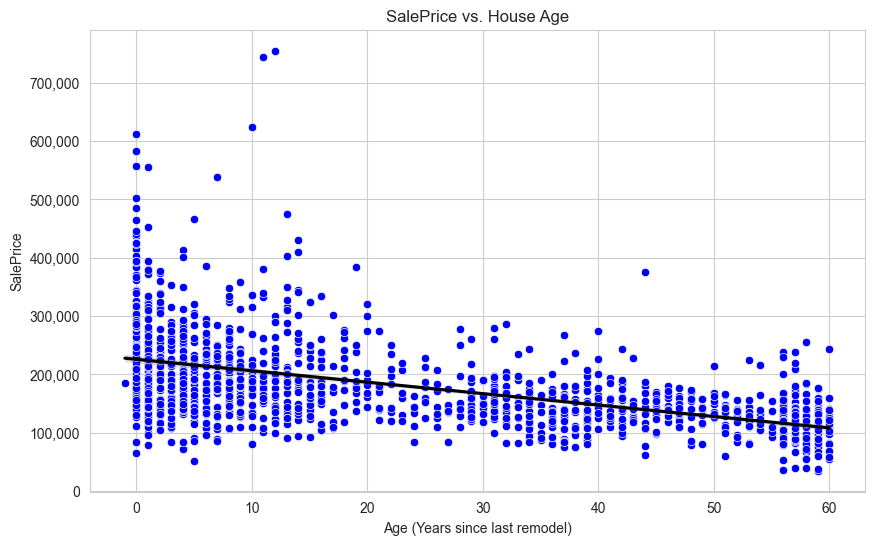

Correlation between SalePrice and Age: -0.51


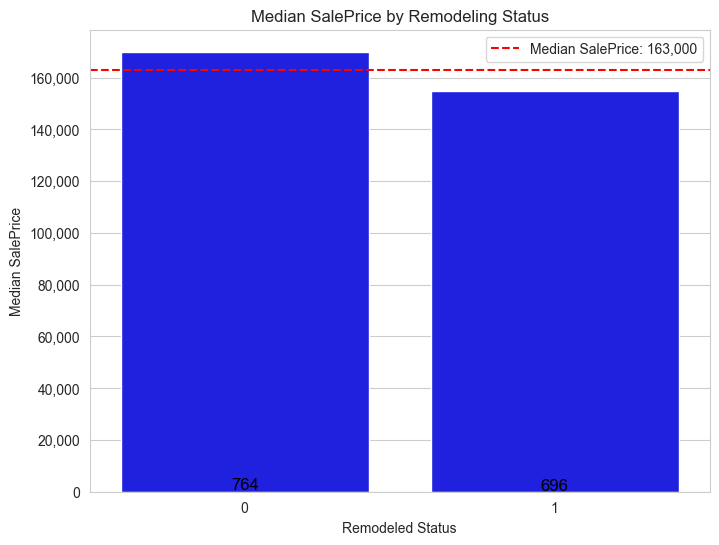


IsNew value counts:
 IsNew
0    2803
1     116
Name: count, dtype: int64


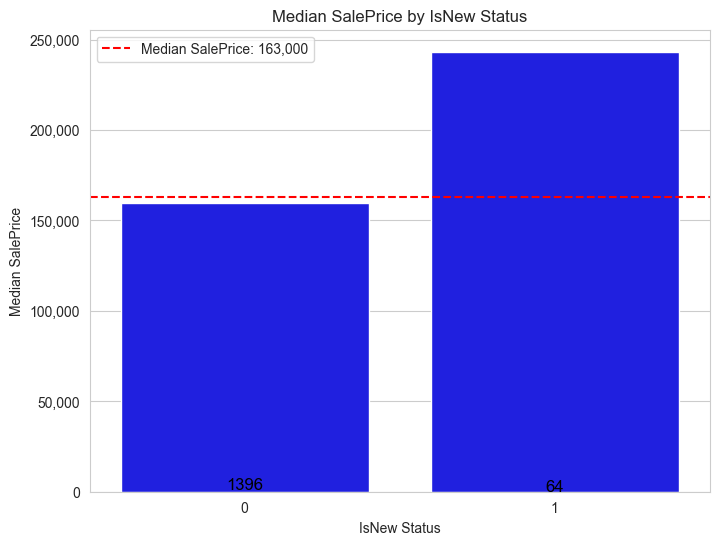

In [34]:
## 7.2 Adding ‘House Age’, ‘Remodeled (Yes/No)’, and IsNew variables

all_data['Remod'] = (all_data['YearBuilt'] != all_data['YearRemodAdd']).astype(int) # 0=No Remodeling, 1=Remodeling
all_data['Age'] = all_data['YrSold'] - all_data['YearRemodAdd']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), color='blue')
sns.regplot(x='Age', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), scatter=False, color='black')
plt.title('SalePrice vs. House Age')
plt.xlabel('Age (Years since last remodel)')
plt.ylabel('SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

print(f"Correlation between SalePrice and Age: {all_data['SalePrice'].corr(all_data['Age']):.2f}") # 오래된 집일수록 가격이 낮아지는 경향이 있음을 확인할 수 있다.

# 리모델링 한 집도 가격이 약간 낮았다
remod_df = all_data.dropna(subset=['SalePrice'])
remod_counts = remod_df['Remod'].value_counts().reset_index()
remod_counts.columns = ['Remod', 'count']
remod_counts['Remod'] = remod_counts['Remod'].map({0: 'No Remodel', 1: 'Remodeled'})

plt.figure(figsize=(8, 6))
sns.barplot(x='Remod', y='SalePrice', data=remod_df, estimator=np.median, color='blue', errorbar=None)
plt.title('Median SalePrice by Remodeling Status')
plt.xlabel('Remodeled Status')
plt.ylabel('Median SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.axhline(y=all_data['SalePrice'].median(), color='red', linestyle='--', label=f'Median SalePrice: {all_data["SalePrice"].median():,.0f}')
plt.legend()

for index, row in remod_counts.iterrows():
    plt.text(index, row['count'], str(row['count']), color='black', ha="center", fontsize=12)

plt.show()

# IsNew 변수 생성: 완전 새집인지 여부, 분석 결과 새집은 116개
all_data['IsNew'] = (all_data['YrSold'] == all_data['YearBuilt']).astype(int)
print("\nIsNew value counts:\n", all_data['IsNew'].value_counts())

isnew_df = all_data.dropna(subset=['SalePrice'])
isnew_counts = isnew_df['IsNew'].value_counts().reset_index()
isnew_counts.columns = ['IsNew', 'count']
isnew_counts['IsNew'] = isnew_counts['IsNew'].map({0: 'Not New', 1: 'New'})

plt.figure(figsize=(8, 6))
sns.barplot(x='IsNew', y='SalePrice', data=isnew_df, estimator=np.median, color='blue', errorbar=None)
plt.title('Median SalePrice by IsNew Status')
plt.xlabel('IsNew Status')
plt.ylabel('Median SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.axhline(y=all_data['SalePrice'].median(), color='red', linestyle='--', label=f'Median SalePrice: {all_data["SalePrice"].median():,.0f}')
plt.legend()

for index, row in isnew_counts.iterrows():
    plt.text(index, row['count'], str(row['count']), color='black', ha="center", fontsize=12)

plt.show()

all_data['YrSold'] = all_data['YrSold'].astype(str) #the numeric version is now not needed anymore


C:\Users\luke\AppData\Local\Temp\ipykernel_39512\3773061213.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\luke\AppData\Local\Temp\ipykernel_39512\3773061213.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


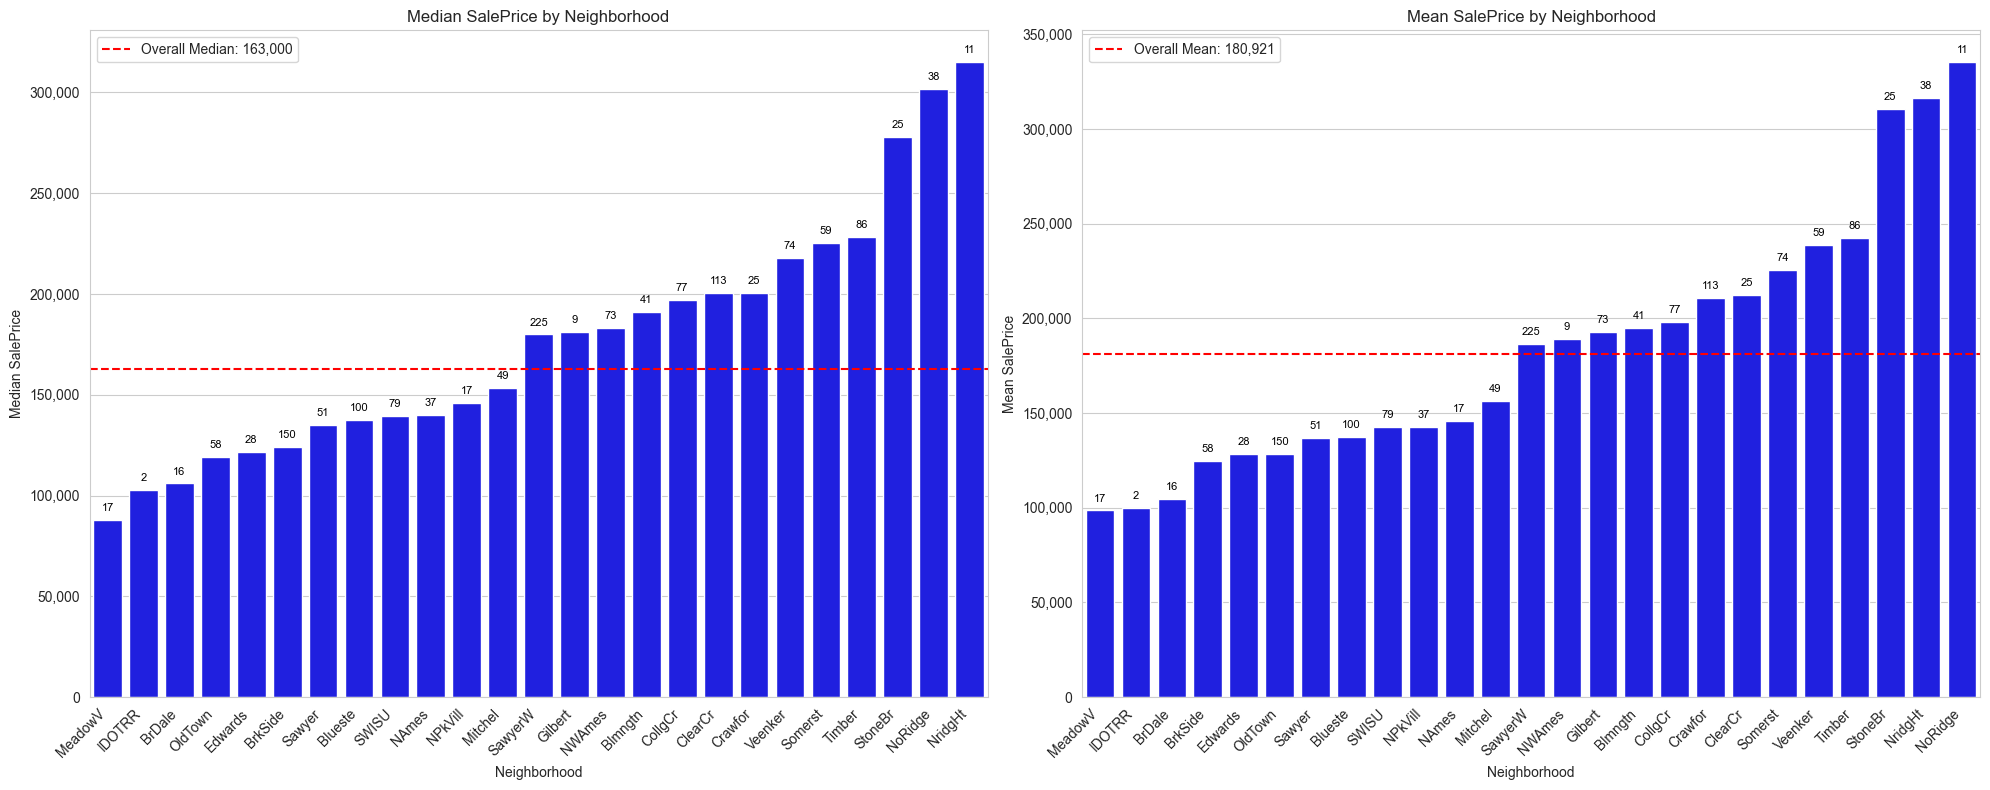


NeighRich value counts:
 NeighRich
1    2471
2     288
0     160
Name: count, dtype: int64


In [36]:
## 7.3 지역(neighborhood)을 합치기: 가격을 기준으로
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

neighborhood_median = all_data.dropna(subset=['SalePrice']).groupby('Neighborhood')['SalePrice'].median().sort_values()
sns.barplot(x=neighborhood_median.index, y=neighborhood_median.values, color='blue', ax=axes[0])
axes[0].set_title('Median SalePrice by Neighborhood')
axes[0].set_xlabel('Neighborhood')
axes[0].set_ylabel('Median SalePrice')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[0].axhline(y=all_data['SalePrice'].median(), color='red', linestyle='--', label=f'Overall Median: {all_data["SalePrice"].median():,.0f}')
axes[0].legend()

# Add counts to median plot
neighborhood_counts = all_data.dropna(subset=['SalePrice']).groupby('Neighborhood').size()
for i, p in enumerate(axes[0].patches):
    count = neighborhood_counts.iloc[i]
    axes[0].annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

neighborhood_mean = all_data.dropna(subset=['SalePrice']).groupby('Neighborhood')['SalePrice'].mean().sort_values()
sns.barplot(x=neighborhood_mean.index, y=neighborhood_mean.values, color='blue', ax=axes[1])
axes[1].set_title('Mean SalePrice by Neighborhood')
axes[1].set_xlabel('Neighborhood')
axes[1].set_ylabel('Mean SalePrice')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[1].axhline(y=all_data['SalePrice'].mean(), color='red', linestyle='--', label=f'Overall Mean: {all_data["SalePrice"].mean():,.0f}')
axes[1].legend()

# Add counts to mean plot
for i, p in enumerate(axes[1].patches):
    count = neighborhood_counts.iloc[i]
    axes[1].annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# 다음과 같이 3개의 그룹으로 나누기로 결정
all_data['NeighRich'] = 1 # Default to middle group
all_data.loc[all_data['Neighborhood'].isin(['StoneBr', 'NridgHt', 'NoRidge']), 'NeighRich'] = 2
all_data.loc[all_data['Neighborhood'].isin(['MeadowV', 'IDOTRR', 'BrDale']), 'NeighRich'] = 0
print("\nNeighRich value counts:\n", all_data['NeighRich'].value_counts())


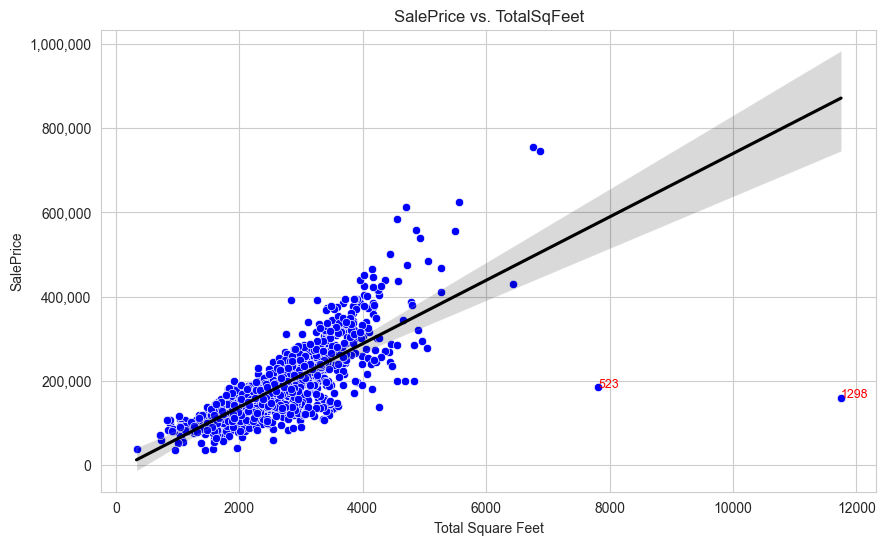

Correlation between SalePrice and TotalSqFeet: 0.78
Correlation after removing outliers: 0.83


In [37]:
## 7.4 all$TotalSqFeet 생성 <- all$GrLivArea + all$TotalBsmtSF
all_data['TotalSqFeet'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSqFeet', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), color='blue')
sns.regplot(x='TotalSqFeet', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), scatter=False, color='black')
plt.title('SalePrice vs. TotalSqFeet')
plt.xlabel('Total Square Feet')
plt.ylabel('SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Outlier annotation (simple text)
outliers_total_sq_feet = all_data.loc[all_data['GrLivArea'] > 4500]
for i, row in outliers_total_sq_feet.dropna(subset=['SalePrice']).iterrows():
    plt.text(row['TotalSqFeet'], row['SalePrice'], str(i), fontsize=9, color='red')

plt.show()

# 상관관계 분석
print(f"Correlation between SalePrice and TotalSqFeet: {all_data['SalePrice'].corr(all_data['TotalSqFeet']):.2f}")

# 이상치 제거 후 상관관계 분석
# R의 인덱스는 1부터 시작하므로 524, 1299. Python에서는 523, 1298.
filtered_salesprice = all_data['SalePrice'].drop(index=[523, 1298]).dropna()
filtered_totalsqfeet = all_data['TotalSqFeet'].drop(index=[523, 1298]).dropna()
print(f"Correlation after removing outliers: {filtered_salesprice.corr(filtered_totalsqfeet):.2f}")


Correlation between SalePrice and TotalPorchSF: 0.20


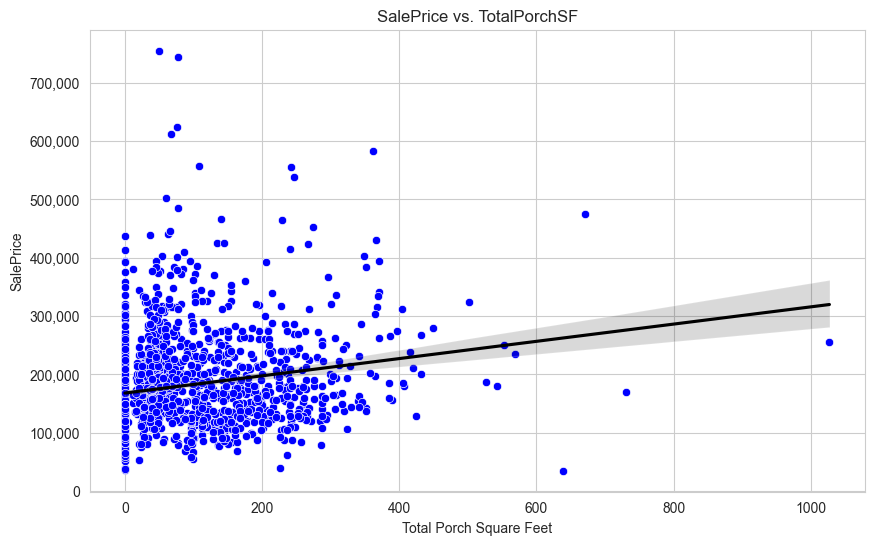

In [39]:
## 7.5 Consolidating Porch variables
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']
print(f"Correlation between SalePrice and TotalPorchSF: {all_data['SalePrice'].corr(all_data['TotalPorchSF']):.2f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPorchSF', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), color='blue')
sns.regplot(x='TotalPorchSF', y='SalePrice', data=all_data.dropna(subset=['SalePrice']), scatter=False, color='black')
plt.title('SalePrice vs. TotalPorchSF')
plt.xlabel('Total Porch Square Feet')
plt.ylabel('SalePrice')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()


In [41]:
# 8. 모델링 준비
## 8.1 상관관계 높은 변수 제거
drop_vars = ['YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'TotalBsmtSF', 'BsmtFinSF1']
all_data = all_data.drop(columns=drop_vars)
print("\nShape after dropping highly correlated variables:", all_data.shape)

## 8.2. 이상치 제거
# R의 524, 1299 인덱스는 Python에서 523, 1298
all_data = all_data.drop(index=[523, 1298]).reset_index(drop=True)
print("Shape after removing outliers (indices 523, 1298):", all_data.shape)

## 8.3 진짜 수치형(numeric) 변수들은 정규화(center & scale) 하고, 범주형(categorical) 변수들은 더미 변수(dummy variables) 로 만들기
# 범주형에 가까운 변수 제거 및 새로운 수치형 파생변수 추가
# Initial numeric variables (before feature engineering & dropping SalePrice, etc.)
initial_numeric_vars = train.select_dtypes(include=np.number).columns.tolist()
initial_numeric_vars = [var for var in initial_numeric_vars if var not in ['Id', 'SalePrice']]

numeric_var_names_final = [col for col in all_data.select_dtypes(include=np.number).columns if col != 'SalePrice']
numeric_var_names_final = [var for var in numeric_var_names_final if var not in ['MSSubClass', 'MoSold', 'YrSold', 'OverallQual', 'OverallCond']]
# Add the new numeric engineered features
numeric_var_names_final.extend(['Age', 'TotalPorchSF', 'TotBathrooms', 'TotalSqFeet'])

# Ensure unique names
numeric_var_names_final = list(set(numeric_var_names_final))

DFnumeric = all_data[numeric_var_names_final].copy()
DFfactors = all_data.select_dtypes(include='object').copy()

print(f'There are {len(DFnumeric.columns)} numeric variables, and {len(DFfactors.columns)} factor variables')

## 8.3.1 왜도처리
for col in DFnumeric.columns:
    if abs(skew(DFnumeric[col])) > 0.8:
        # Use boxcox1p for handling zeros (add 1 if any value is 0 or negative)
        # In R, log(x+1) is used, which is equivalent to np.log1p(x)
        DFnumeric[col] = np.log1p(DFnumeric[col])

scaler = StandardScaler()
DFnorm = pd.DataFrame(scaler.fit_transform(DFnumeric), columns=DFnumeric.columns, index=DFnumeric.index)
print("DFnorm shape:", DFnorm.shape)

## 8.3.2 범주형 변수들 원-핫 인코딩
DFdummies = pd.get_dummies(DFfactors, dummy_na=False)
print("DFdummies shape:", DFdummies.shape)

### 8.3.3 원-핫 인코딩된 변수들 중에서 정보가 부족한 열들을 제거
# SalePrice가 NaN이 아닌 행의 수 (훈련 데이터의 원래 크기)
num_train_rows = train.shape[0] - 2 # 2 outliers removed

# 테스트셋에 아예 등장하지 않는 변수 제거
test_dummy_part = DFdummies.iloc[num_train_rows:].sum()
zerocol_test = test_dummy_part[test_dummy_part == 0].index.tolist()
print("Columns with zero sum in test set:", zerocol_test)
DFdummies = DFdummies.drop(columns=zerocol_test)

# 훈련셋에 아예 등장하지 않는 변수 제거
train_dummy_part = DFdummies.iloc[:num_train_rows].sum()
zerocol_train = train_dummy_part[train_dummy_part == 0].index.tolist()
print("Columns with zero sum in train set:", zerocol_train)
DFdummies = DFdummies.drop(columns=zerocol_train)

# 훈련셋에서 1값이 10개 미만인 변수들
few_ones = train_dummy_part[(train_dummy_part > 0) & (train_dummy_part < 10)].index.tolist()
print("Columns with less than 10 ones in train set:", few_ones)
DFdummies = DFdummies.drop(columns=few_ones)

print("DFdummies shape after rare feature removal:", DFdummies.shape)

# 정규화된 수치형 변수(DFnorm)와 정제된 더미 변수(DFdummies)를 합쳐서 최종 데이터셋(combined) 생성
combined = pd.concat([DFnorm, DFdummies], axis=1)
print("Combined data shape:", combined.shape)



Shape after dropping highly correlated variables: (2919, 80)
Shape after removing outliers (indices 523, 1298): (2917, 80)
There are 51 numeric variables, and 26 factor variables
DFnorm shape: (2917, 51)
DFdummies shape: (2917, 205)
Columns with zero sum in test set: ['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW', 'Electrical_Mix', 'MiscFeature_TenC']
Columns with zero sum in train set: ['MSSubClass_1,5 story PUD all']
Columns with less than 10 ones in train set: ['MSSubClass_1 story unf attic', 'LotConfig_FR3', 'Neighborhood_Blueste', 'Neighborhood_NPkVill', 'Condition1_PosA', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1s

Original SalePrice Skewness: 1.88
Log-transformed SalePrice Skewness: 0.12


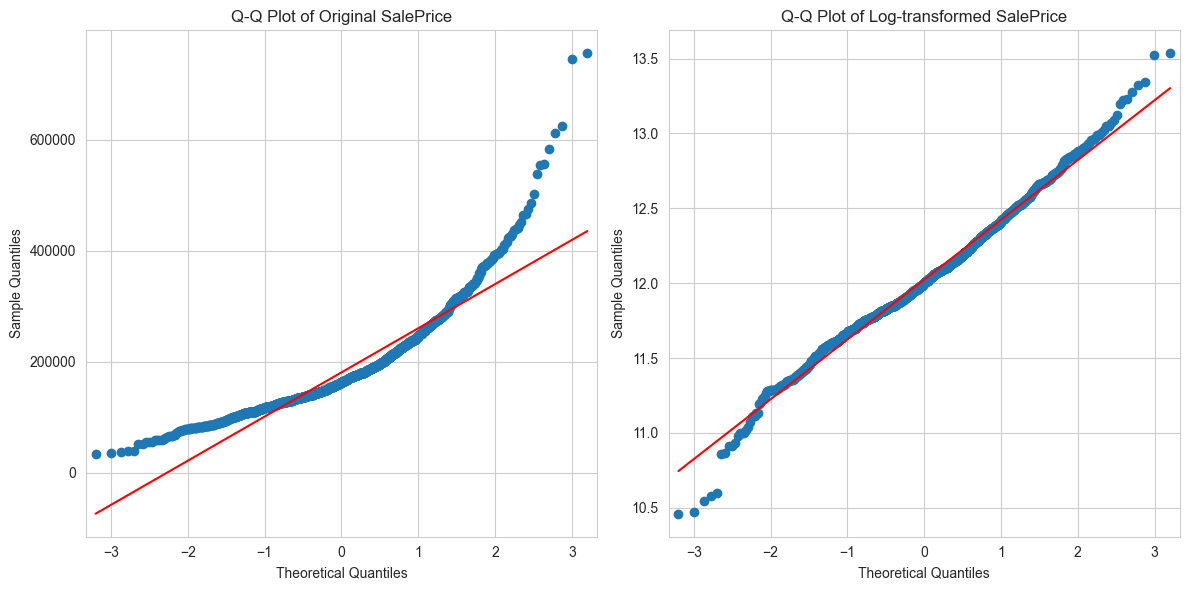

In [42]:
## 8.4 Q-Q 플롯을 통해 타겟 변수의 왜도 조절
sale_price_original = all_data['SalePrice'].dropna()
print(f"Original SalePrice Skewness: {skew(sale_price_original):.2f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
import statsmodels.api as sm
sm.qqplot(sale_price_original, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Original SalePrice')

# 로그변환
all_data['SalePrice'] = np.log(all_data['SalePrice']) # default is the natural logarithm, "+1" is not necessary as there are no 0's
sale_price_log = all_data['SalePrice'].dropna()
print(f"Log-transformed SalePrice Skewness: {skew(sale_price_log):.2f}")

plt.subplot(1, 2, 2)
sm.qqplot(sale_price_log, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Log-transformed SalePrice')

plt.tight_layout()
plt.show()


In [43]:
## 8.5 Composing train and test sets
train_rows = all_data['SalePrice'].notna()
train_final = combined[train_rows]
test_final = combined[~train_rows]

y_train_log = all_data.loc[train_rows, 'SalePrice']

print("Final train set shape:", train_final.shape)
print("Final test set shape:", test_final.shape)
print("Target variable (y_train_log) shape:", y_train_log.shape)


Final train set shape: (1458, 202)
Final test set shape: (1459, 202)
Target variable (y_train_log) shape: (1458,)


In [44]:
# 9. 모델링
# 9.1. Lasso Regression
np.random.seed(27042018) # Set numpy seed for reproducibility

# Lasso 모델 정의 및 Grid Search
lasso = Lasso(max_iter=10000) # Increased max_iter for convergence
lasso_params = {'alpha': np.arange(0.001, 0.1, 0.0005)}
kf = KFold(n_splits=5, shuffle=True, random_state=27042018)

lasso_grid_search = GridSearchCV(lasso, lasso_params, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
lasso_grid_search.fit(train_final, y_train_log)

best_lasso_alpha = lasso_grid_search.best_params_['alpha']
best_lasso_rmse = np.sqrt(-lasso_grid_search.best_score_)

print(f"Best Lasso alpha: {best_lasso_alpha}")
print(f"Min Lasso RMSE: {best_lasso_rmse:.4f}")

# 최적의 Lasso 모델로 예측
lasso_mod = lasso_grid_search.best_estimator_
lasso_pred_log = lasso_mod.predict(test_final)
predictions_lasso = np.exp(lasso_pred_log) # 역변환 (로그 스케일 되돌리기)

print("\nLasso Predictions (first 5):\n", predictions_lasso[:5])

# 변수 중요도 (Lasso는 계수 크기로 중요도 확인)
lasso_coef = pd.Series(lasso_mod.coef_, index=train_final.columns)
vars_selected = (lasso_coef != 0).sum()
vars_not_selected = (lasso_coef == 0).sum()

print(f'Lasso uses {vars_selected} variables in its model, and did not select {vars_not_selected} variables.')
print("Top 10 most important Lasso features (by absolute coefficient value):\n", abs(lasso_coef).sort_values(ascending=False).head(10))


Best Lasso alpha: 0.001
Min Lasso RMSE: 0.1251

Lasso Predictions (first 5):
 [111761.33400135 159030.65712072 189232.84084241 199006.51259065
 194428.18570822]
Lasso uses 80 variables in its model, and did not select 122 variables.
Top 10 most important Lasso features (by absolute coefficient value):
 MSZoning_C (all)         0.184383
Neighborhood_Crawfor     0.098890
TotalSqFeet              0.091791
GrLivArea                0.084122
Exterior1st_BrkFace      0.057793
CentralAir_N             0.056940
Neighborhood_Somerst     0.050718
SaleType_New             0.048275
SaleCondition_Abnorml    0.048253
Neighborhood_Edwards     0.043437
dtype: float64


회귀 분석에서 모델이 훈련 데이터에 너무 과도하게 맞춰져서 새로운 데이터에 대한 예측 성능이 떨어지는 것(과적합)을 방지하기 위한 방법으로 정규화 기법을 사용한다. Lasso와 Ridge, 그리고 Elastic Net Regression은 대표적인 정규화 방법이다.

| 구분           | Ridge Regression             | Lasso Regression             | Elastic Net Regression     |
| -------------- | ---------------------------- | ---------------------------- | -------------------------- |
| **규제 방식** | L2 정규화 (제곱합)           | L1 정규화 (절댓값합)         | L1 + L2 혼합               |
| **수식** | **Loss + λ × Σ(β²)** | **Loss + λ × Σ(\|β\|)** | **Loss + λ × [α × Σ(\|β\|) + (1-α) × Σ(β²)]** |
| **주요 목적** | **모델 복잡도 감소** | **변수 선택(희소성)** | **Ridge + Lasso 장점 결합** |
| **계수 감소** | 계수를 **0에 가깝게** 줄임 (완전히 0은 아님) | **불필요한 변수 계수를 0으로** 만들어 제거 | 일부 변수 제거 + 일부는 축소 |
| **변수 선택 기능** | 없음                      | 있음 (자동 선택)             | 있음                       |
| **다중공선성 처리** | 유사한 변수들 **모두 남김** (비슷하게 축소) | 유사한 변수 중 **하나만 선택** | 유사한 변수들을 적절히 조절 |
| **적합 데이터** | 모든 변수가 유의미할 때      | 중요한 변수만 일부일 때      | 변수 수가 많고 상관관계가 높을 때 |

🔍 쉽게 비유하면

- Ridge: 변수들을 모두 남기되, 조심스럽게 약하게 만든다.

- Lasso: 쓸모없는 변수는 과감히 제거(=계수 0) 한다.

- Elastic Net: 둘의 장점을 혼합해서 상황에 맞게 조절한다.

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best XGBoost parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 1000, 'subsample': 1}
Min XGBoost RMSE: 0.1254
[0]	train-rmse:0.38745+0.00310	test-rmse:0.38765+0.01277
[50]	train-rmse:0.15989+0.00177	test-rmse:0.17209+0.00902
[100]	train-rmse:0.12630+0.00139	test-rmse:0.14630+0.00725
[150]	train-rmse:0.11291+0.00131	test-rmse:0.13708+0.00657
[200]	train-rmse:0.10553+0.00102	test-rmse:0.13268+0.00614
[250]	train-rmse:0.10058+0.00081	test-rmse:0.13004+0.00593
[300]	train-rmse:0.09693+0.00059	test-rmse:0.12842+0.00602
[350]	train-rmse:0.09387+0.00046	test-rmse:0.12747+0.00608
[400]	train-rmse:0.09119+0.00038	test-rmse:0.12666+0.00624
[450]	train-rmse:0.08882+0.00033	test-rmse:0.12627+0.00631
[500]	train-rmse:0.08664+0.00039	test-rmse:0.12596+0.00634
[550]	train-rmse:0.08462+0.00044	test-rmse:0.12571+0.00658
[600]	train-rmse:0.08262+0.00050	test-rmse:0.12

C:\Users\luke\AppData\Local\Temp\ipykernel_39512\2740891693.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


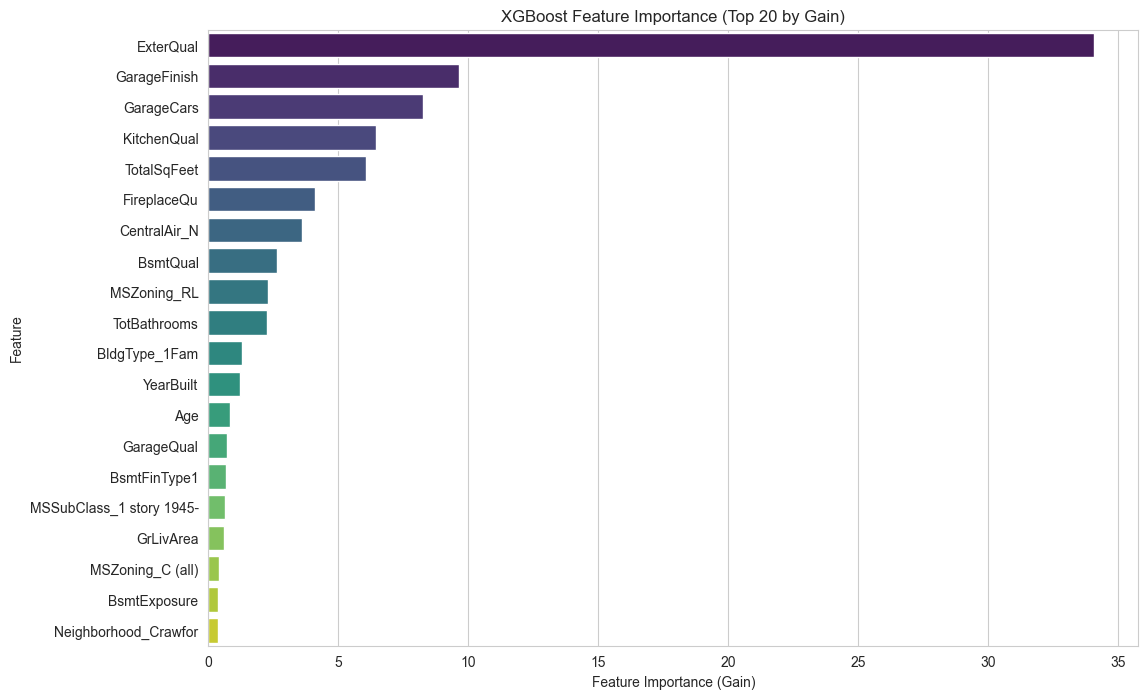

In [45]:
# 9.2. XGBoost
xgb_grid_params = {
    'n_estimators': [1000],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [2, 3, 4, 5, 6],
    'gamma': [0],
    'colsample_bytree': [1],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [1]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=27042018, n_jobs=-1)

xgb_grid_search = GridSearchCV(xgb_model, xgb_grid_params, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
xgb_grid_search.fit(train_final, y_train_log)

best_xgb_params = xgb_grid_search.best_params_
best_xgb_rmse = np.sqrt(-xgb_grid_search.best_score_)

print(f"Best XGBoost parameters: {best_xgb_params}")
print(f"Min XGBoost RMSE: {best_xgb_rmse:.4f}")

# train the model using the best iteration found by cross validation (using xgb.cv to find best n_rounds)
dtrain = xgb.DMatrix(train_final, label=y_train_log)
dtest = xgb.DMatrix(test_final)

default_param_xgb = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'eta': best_xgb_params['learning_rate'],
    'gamma': best_xgb_params['gamma'],
    'max_depth': best_xgb_params['max_depth'],
    'min_child_weight': best_xgb_params['min_child_weight'],
    'subsample': best_xgb_params['subsample'],
    'colsample_bytree': best_xgb_params['colsample_bytree'],
    'seed': 27042018
}

xgbcv = xgb.cv(params=default_param_xgb, dtrain=dtrain, num_boost_round=5000, nfold=5,
               metrics={'rmse'}, early_stopping_rounds=100, verbose_eval=50, seed=27042018)

best_nrounds = xgbcv.shape[0]
print(f"Best number of boosting rounds for XGBoost: {best_nrounds}")

xgb_mod = xgb.train(params=default_param_xgb, dtrain=dtrain, num_boost_round=best_nrounds)

xgb_pred_log = xgb_mod.predict(dtest)
predictions_XGB = np.exp(xgb_pred_log) # 역변환 (로그 스케일 되돌리기)
print("\nXGBoost Predictions (first 5):\n", predictions_XGB[:5])

# view variable importance plot
xgb_importance = xgb_mod.get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': list(xgb_importance.keys()), 'Importance': list(xgb_importance.values())})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('XGBoost Feature Importance (Top 20 by Gain)')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Feature')
plt.show()


In [46]:
# 9.3 Averaging predictions
# 라소와 XGBoost의 예측값을 평균내어 최종 예측값을 구한다.
# R 코드에서는 Lasso 예측에 2배 가중치를 주었으므로, 동일하게 적용합니다.
sub_avg = pd.DataFrame({
    "Id": test_labels,
    "SalePrice": (predictions_XGB + 2 * predictions_lasso) / 3
})

print("\nFinal Averaged Predictions (first 5):\n", sub_avg.head())

# 선택적으로 제출 파일을 저장할 수 있습니다.
# sub_avg.to_csv('submission_averaged.csv', index=False)
# print("Submission file 'submission_averaged.csv' created successfully.")



Final Averaged Predictions (first 5):
      Id      SalePrice
0  1461  112375.639334
1  1462  159792.276622
2  1463  189761.737645
3  1464  194649.492769
4  1465  194830.254014
